# 대구 교통사고 예측 AI

**할일**
1. ECLO를 바로 회귀하는 모델
2. 사망자수, 중상자수, 경상자수, 부상자수를 회귀하고 ECLO를 구하는 모델
3. 사망자, 중상자, 경상자, 부상자 여부를 확인하고 회귀하는 모델

In [1]:
%cd /content/drive/MyDrive/dacon/daegu_ai

/content/drive/MyDrive/dacon/daegu_ai


아래의 코드 실행 후 Runtime Restart

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,090 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120899 files and dire

In [3]:
!pip install autogluon pytorch_tabnet -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.7/416.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os, gc, random
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor, XGBClassifier
import lightgbm as lgb
import bisect

import warnings
warnings.filterwarnings(action='ignore')
plt.rc('font', family='NanumBarunGothic')

In [3]:
from catboost import CatBoostRegressor, CatBoostClassifier
from pytorch_tabnet.tab_model import TabNetRegressor
from autogluon.tabular import TabularPredictor, TabularDataset

In [4]:
import autogluon

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    autogluon.core.utils.random.seed(seed)

SEED = 42
seed_everything(SEED) # Seed 고정

In [6]:
df_train_org = pd.read_csv('./open/train.csv')
df_test_org = pd.read_csv('./open/test.csv')

# Merge

In [7]:
df_parking = pd.read_csv('./parking_by_place.csv')

In [8]:
df_cctv = pd.read_csv('./cctv_feature_1208.csv', index_col=0)

In [9]:
df_light_train = pd.read_csv("./train_light.csv")
df_light_test = pd.read_csv("./test_light.csv")

In [10]:
df_child_taxi_train = pd.read_csv('./data_child_taxi.csv', index_col=0).drop(columns=df_train_org.columns)

In [11]:
df_ice = pd.read_csv('./df_ice.csv', index_col=0).drop(columns='id')
df_old = pd.read_csv('./df_old.csv', index_col=0).drop(columns='id')
df_pds = pd.read_csv('./df_pds.csv', index_col=0).drop(columns='id')
df_trk = pd.read_csv('./df_trk.csv', index_col=0).drop(columns='id')
df_wlk = pd.read_csv('./df_wlk.csv', index_col=0).drop(columns='id')

In [12]:
df_merged_train = pd.merge(df_light_train, df_parking, on='시군구', how='left')
df_merged_test = pd.merge(df_light_test, df_parking, on='시군구', how='left')

In [13]:
df_merged_train = pd.merge(left=df_merged_train, right=df_cctv, on='시군구', how='left')
df_merged_test = pd.merge(left=df_merged_test, right=df_cctv, on='시군구', how='left')

In [14]:
loc_taxi_info = pd.read_csv('./data_child_taxi.csv', index_col=0)[['시군구','보호구역도로폭_카테고리', '어린이보호구역 개수', '어보구CCTV설치비율', '하차', '승차']]

In [15]:
lti_group = loc_taxi_info.groupby('시군구').mean()

In [16]:
df_merged_train = pd.merge(left=df_merged_train, right=lti_group, on='시군구', how='left')
df_merged_test = pd.merge(left=df_merged_test, right=lti_group, on='시군구', how='left')

In [117]:
[col for col in df_old.columns if 'sum' in col or 'total' in col]

['occrrnc_cnt_sum',
 'caslt_cnt_sum',
 'dth_dnv_cnt_sum',
 'se_dnv_cnt_sum',
 'sl_dnv_cnt_sum',
 'wnd_dnv_cnt_sum',
 'total']

In [17]:
df_total_danger = pd.concat([df_ice['시군구'], (df_ice.iloc[:,1:] + df_old.iloc[:,1:] + df_pds.iloc[:,1:] + df_trk.iloc[:,1:] + df_wlk.iloc[:,1:])],axis=1)

In [18]:
df_total_danger = df_total_danger[['시군구','count'] + [col for col in df_old.columns if 'sum' in col or 'total' in col]]

<Axes: >

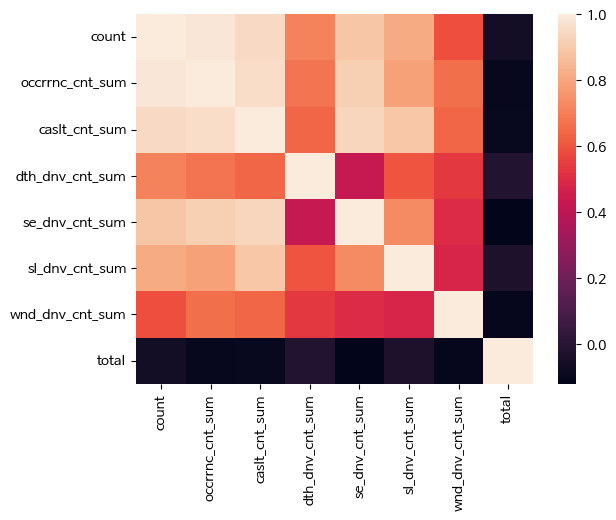

In [91]:
sns.heatmap(df_total_danger.iloc[:,1:].corr())

In [19]:
df_merged_train = pd.merge(left=df_merged_train, right=df_total_danger, on='시군구', how='left')
df_merged_test = pd.merge(left=df_merged_test, right=df_total_danger, on='시군구', how='left')

In [20]:
df_merged_train.shape[0] == df_train_org.shape[0]

True

In [21]:
df_merged_test.shape[0] == df_test_org.shape[0]

True

In [22]:
df_merged_train.shape

(39609, 76)

# EDA

In [125]:
df_train = df_train_org.copy()
df_test = df_test_org.copy()

In [23]:
df_train = df_merged_train.copy()
df_test = df_merged_test.copy()

## Data Summary

In [ ]:
df_train.head()

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


In [ ]:
df_test.head()

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

In [ ]:
df_train.isna().sum()

ID               0
사고일시             0
요일               0
기상상태             0
시군구              0
도로형태             0
노면상태             0
사고유형             0
사고유형 - 세부분류      0
법규위반             0
가해운전자 차종         0
가해운전자 성별         0
가해운전자 연령         0
가해운전자 상해정도       0
피해운전자 차종       991
피해운전자 성별       991
피해운전자 연령       991
피해운전자 상해정도     991
사망자수             0
중상자수             0
경상자수             0
부상자수             0
ECLO             0
dtype: int64

In [ ]:
df_test.isna().sum()

ID      0
사고일시    0
요일      0
기상상태    0
시군구     0
도로형태    0
노면상태    0
사고유형    0
dtype: int64

In [ ]:
df_train.describe()

,사망자수,중상자수,경상자수,부상자수,ECLO
count,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000
mean,0.007776,0.262365,1.070085,0.126865,4.726704
std,0.090109,0.500845,0.992034,0.394670,3.207206
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000
50%,0.000000,0.000000,1.000000,0.000000,3.000000
75%,0.000000,0.000000,1.000000,0.000000,6.000000
max,2.000000,6.000000,22.000000,10.000000,74.000000


In [ ]:
df_train.nunique()

ID             39609
사고일시           18057
요일                 7
기상상태               6
시군구              199
도로형태              11
노면상태               6
사고유형               3
사고유형 - 세부분류       14
법규위반              11
가해운전자 차종          12
가해운전자 성별           3
가해운전자 연령          89
가해운전자 상해정도         6
피해운전자 차종          13
피해운전자 성별           3
피해운전자 연령          97
피해운전자 상해정도         6
사망자수               3
중상자수               7
경상자수              18
부상자수               9
ECLO              46
dtype: int64

In [ ]:
for column in df_train.columns:
  print(column,':')
  if len(df_train[column].unique()) < 50:
    print(df_train[column].unique())
  print('-'*100)

ID :
----------------------------------------------------------------------------------------------------
사고일시 :
----------------------------------------------------------------------------------------------------
요일 :
['화요일' '수요일' '목요일' '금요일' '토요일' '일요일' '월요일']
----------------------------------------------------------------------------------------------------
기상상태 :
['맑음' '흐림' '기타' '비' '안개' '눈']
----------------------------------------------------------------------------------------------------
시군구 :
----------------------------------------------------------------------------------------------------
도로형태 :
['단일로 - 기타' '교차로 - 교차로안' '기타 - 기타' '단일로 - 터널' '단일로 - 지하차도(도로)내' '단일로 - 교량'
 '교차로 - 교차로횡단보도내' '주차장 - 주차장' '교차로 - 교차로부근' '단일로 - 고가도로위' '미분류 - 미분류']
----------------------------------------------------------------------------------------------------
노면상태 :
['건조' '젖음/습기' '서리/결빙' '기타' '침수' '적설']
--------------------------------------------------------------------------------------------

여기서 기타불명도 `nan` 값으로 판단해야 될 것 같다.

## 파생변수생성 및 데이터 전처리

In [24]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

df_train[['연', '월', '일', '시간']] = df_train_org['사고일시'].str.extract(time_pattern)
df_train['월일'] = df_train['월'] + df_train['일']
df_train[['연', '월', '일', '시간']] = df_train[['연', '월', '일', '시간']].apply(pd.to_numeric)
df_train = df_train.drop(columns=['사고일시'])

df_test[['연', '월', '일', '시간']] = df_test_org['사고일시'].str.extract(time_pattern)
df_test['월일'] = df_test['월'] + df_test['일']
df_test[['연', '월', '일', '시간']] = df_test[['연', '월', '일', '시간']].apply(pd.to_numeric)
df_test = df_test.drop(columns=['사고일시'])

In [25]:
location_pattern = r'(\S+) (\S+) (\S+)'

df_train[['도시', '구', '동']] = df_train_org['시군구'].str.extract(location_pattern)
df_train = df_train.drop(columns=['시군구','도시']) # 도시는 모두 대구광역시

df_test[['도시', '구', '동']] = df_test_org['시군구'].str.extract(location_pattern)
df_test = df_test.drop(columns=['시군구','도시'])

In [ ]:
road_pattern = r'(.+) - (.+)'

df_train[['도로형태1', '도로형태2']] = df_train_org['도로형태'].str.extract(road_pattern)
df_train = df_train.drop(columns=['도로형태'])

df_test[['도로형태1', '도로형태2']] = df_test_org['도로형태'].str.extract(road_pattern)
df_test = df_test.drop(columns=['도로형태'])

In [ ]:
df_train.loc[:,'가해운전자 연령'][df_train['가해운전자 연령']=='미분류'] = [np.nan] * len(df_train[df_train['가해운전자 연령']=='미분류'])
df_train.loc[:,'피해운전자 연령'][df_train['피해운전자 연령']=='미분류'] = [np.nan] * len(df_train[df_train['피해운전자 연령']=='미분류'])
df_train.loc[:,'가해운전자 연령'][~df_train['가해운전자 연령'].isna()] = df_train.loc[:,'가해운전자 연령'][~df_train['가해운전자 연령'].isna()].str.replace('세','').str.replace('이상','').astype(int)
df_train.loc[:,'피해운전자 연령'][~df_train['피해운전자 연령'].isna()] = df_train.loc[:,'피해운전자 연령'][~df_train['피해운전자 연령'].isna()].str.replace('세','').str.replace('이상','').astype(int)

# 연령 결측치 중앙값으로 채운다
# df_train['가해운전자 연령'] = df_train['가해운전자 연령'].fillna(df_train['가해운전자 연령'].median())
# df_train['피해운전자 연령'] = df_train['피해운전자 연령'].fillna(df_train['피해운전자 연령'].median())

In [ ]:
df_train

## 분포 확인

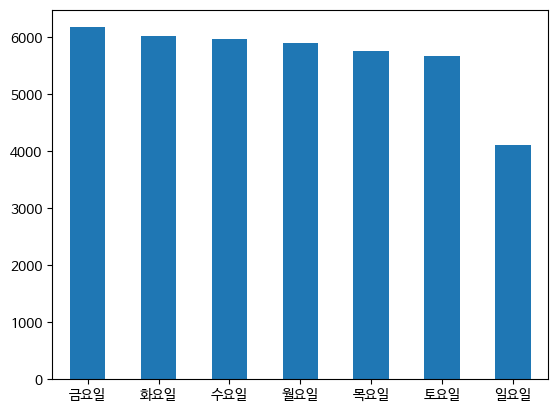

In [ ]:
df_train['요일'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

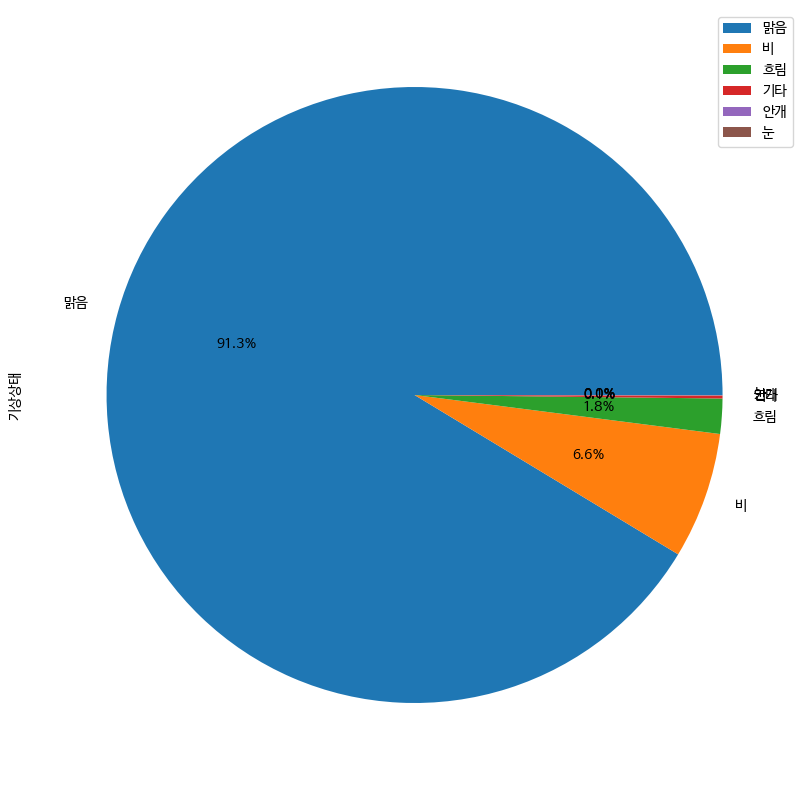

In [ ]:
plt.figure(figsize=(10,10))
df_train['기상상태'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.legend()
plt.show()

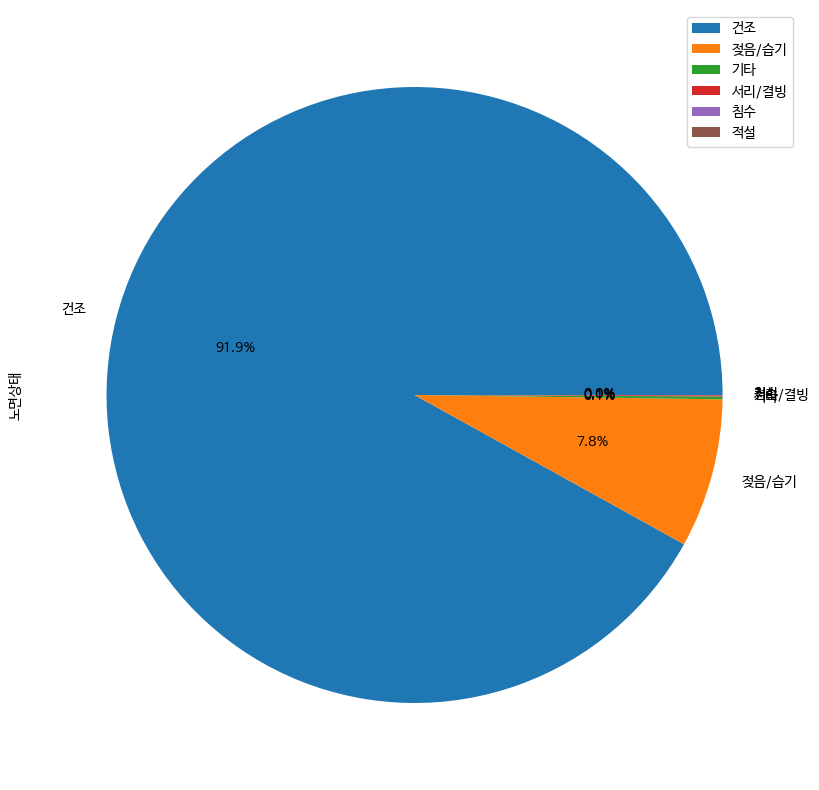

In [ ]:
plt.figure(figsize=(10,10))
df_train['노면상태'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.legend()
plt.show()

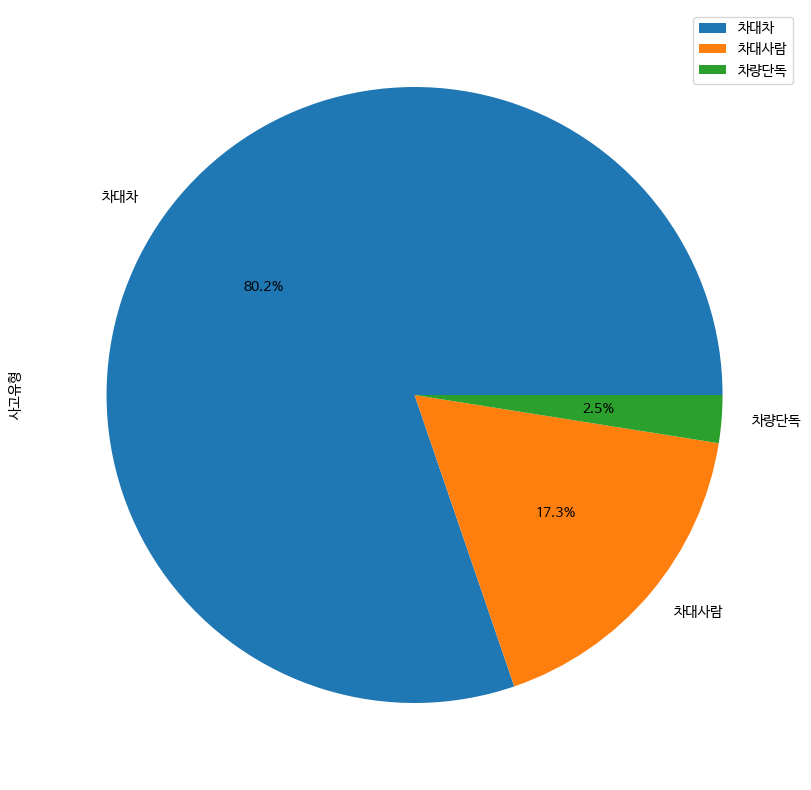

In [ ]:
plt.figure(figsize=(10,10))
df_train['사고유형'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.legend()
plt.show()

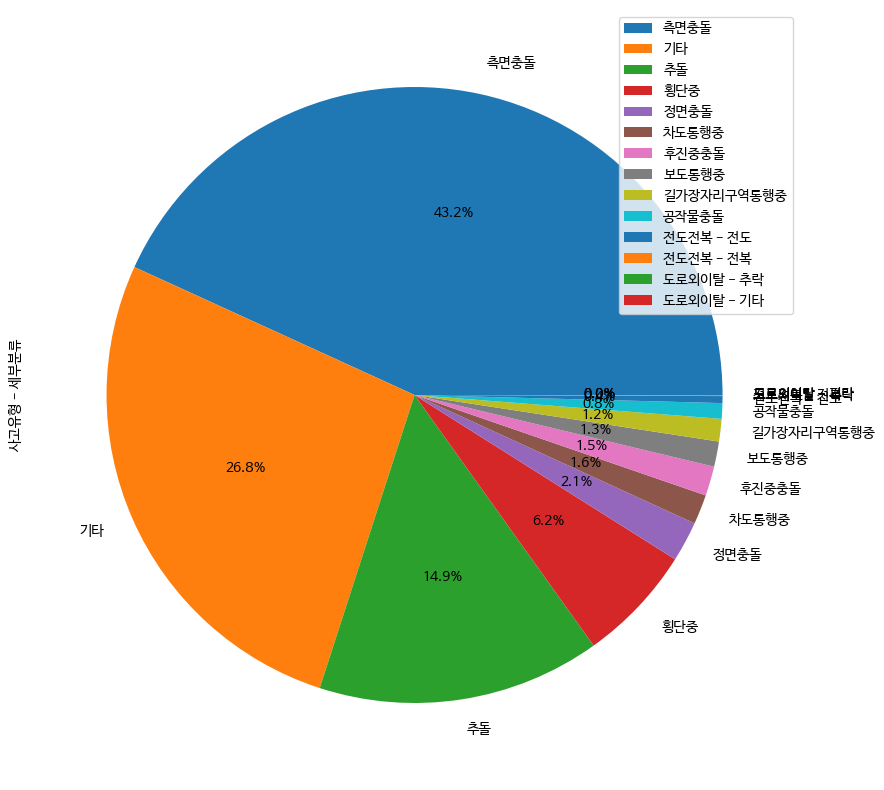

In [ ]:
plt.figure(figsize=(10,10))
df_train['사고유형 - 세부분류'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.legend()
plt.show()

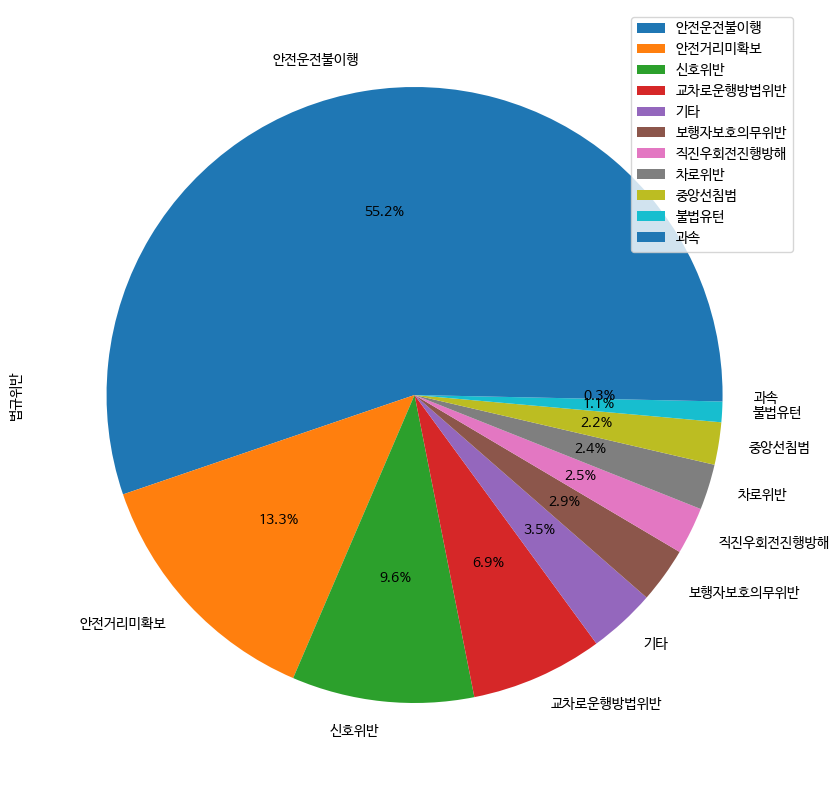

In [ ]:
plt.figure(figsize=(10,10))
df_train['법규위반'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.legend()
plt.show()

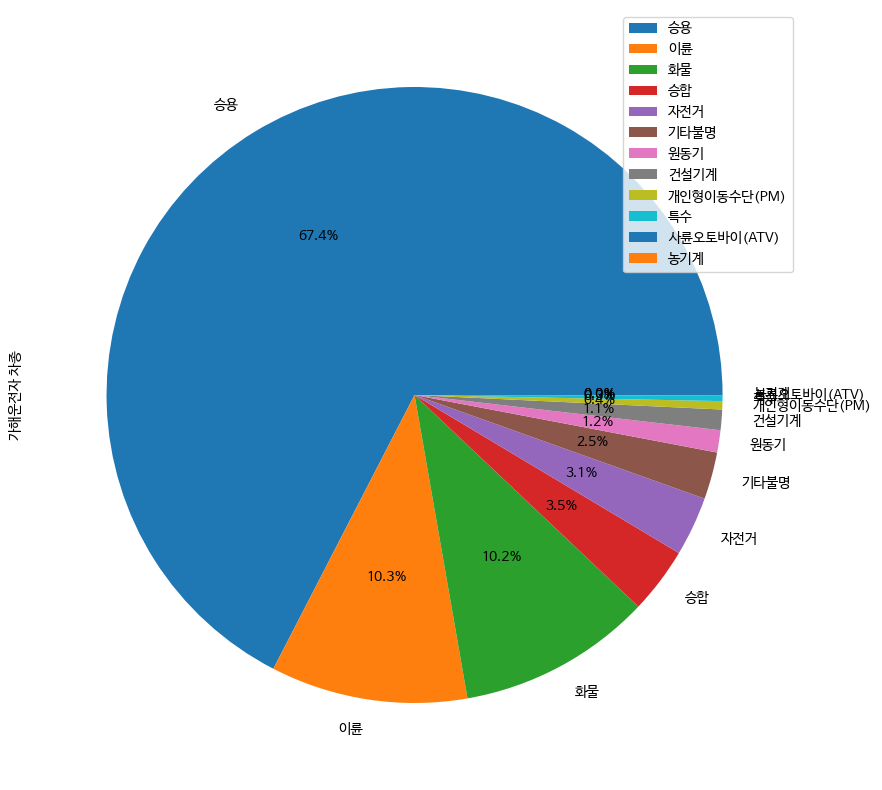

In [ ]:
plt.figure(figsize=(10,10))
df_train['가해운전자 차종'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.legend()
plt.show()

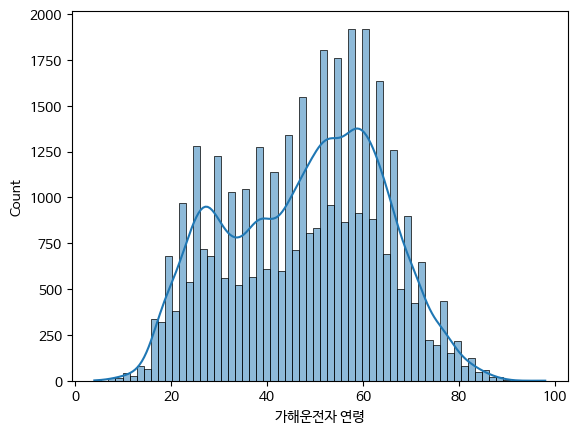

In [ ]:
sns.histplot(df_train['가해운전자 연령'], kde=True)
plt.show()

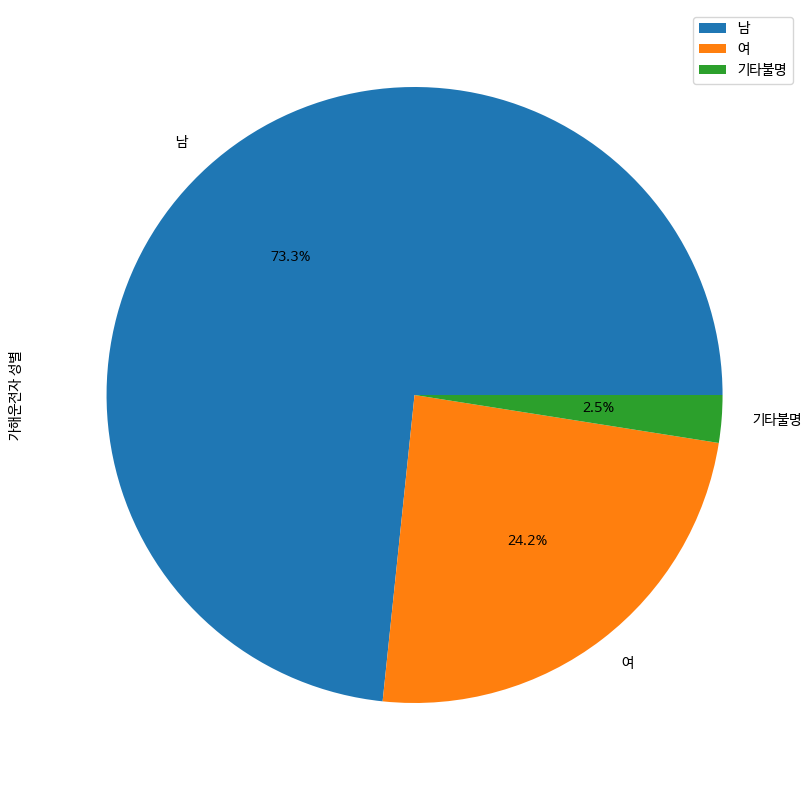

In [ ]:
plt.figure(figsize=(10,10))
df_train['가해운전자 성별'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.legend()
plt.show()

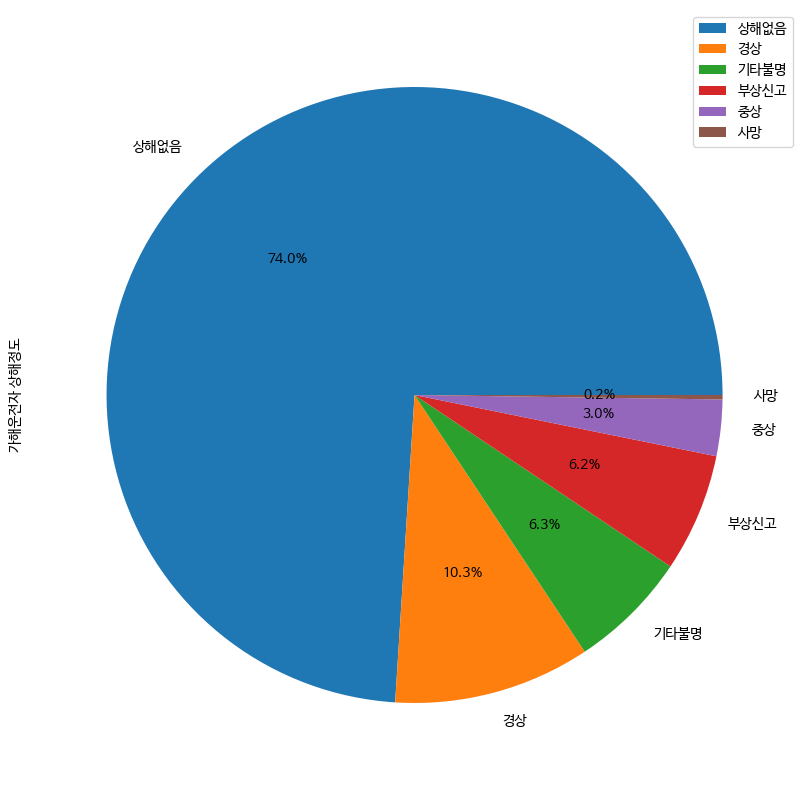

In [ ]:
plt.figure(figsize=(10,10))
df_train['가해운전자 상해정도'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.legend()
plt.show()

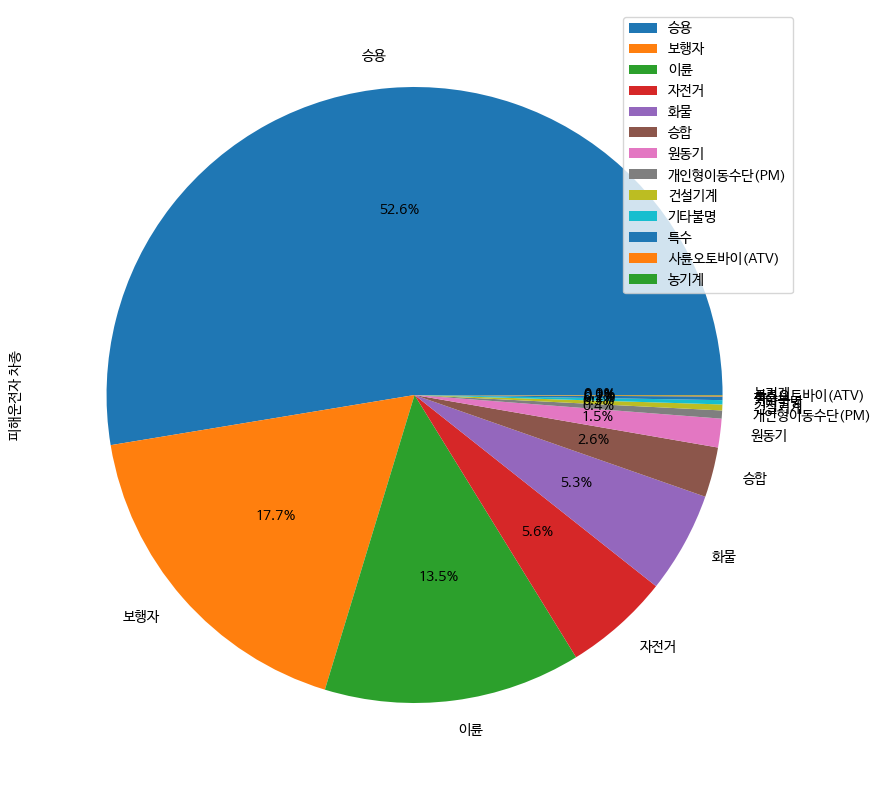

In [ ]:
plt.figure(figsize=(10,10))
df_train['피해운전자 차종'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.legend()
plt.show()

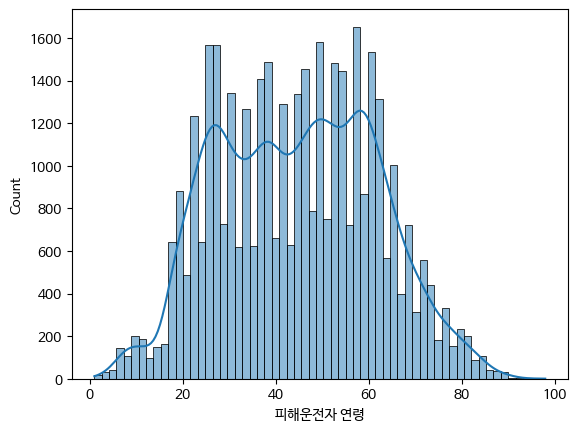

In [ ]:
sns.histplot(df_train['피해운전자 연령'], kde=True)
plt.show()

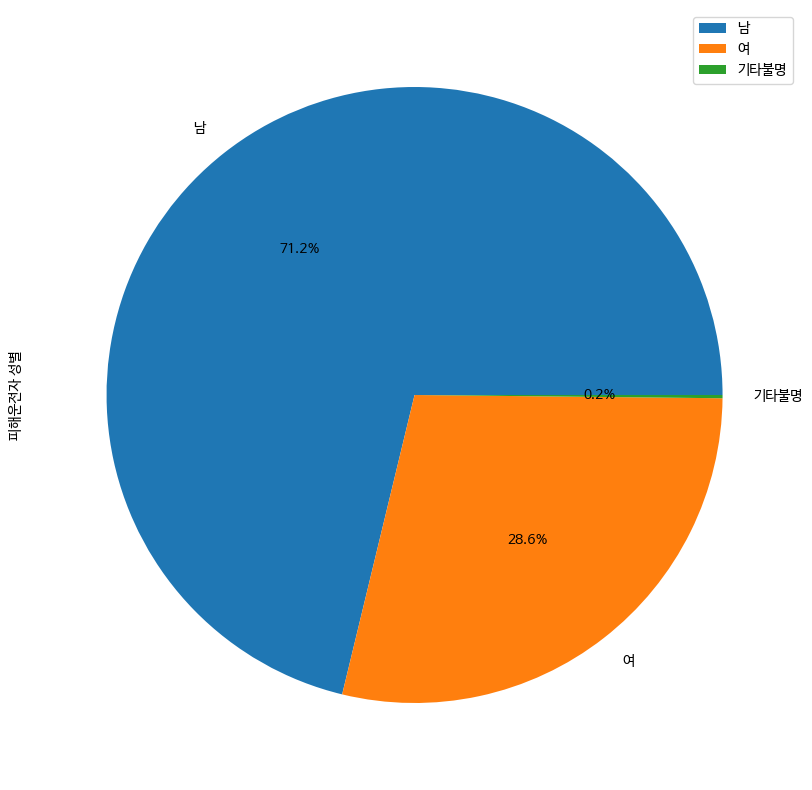

In [ ]:
plt.figure(figsize=(10,10))
df_train['피해운전자 성별'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.legend()
plt.show()

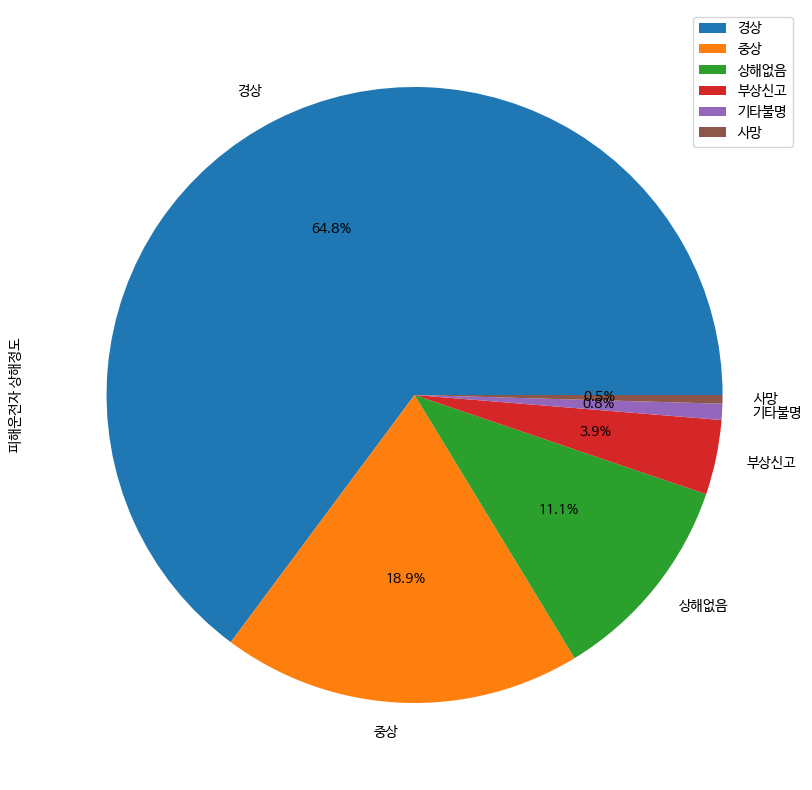

In [ ]:
plt.figure(figsize=(10,10))
df_train['피해운전자 상해정도'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.legend()
plt.show()

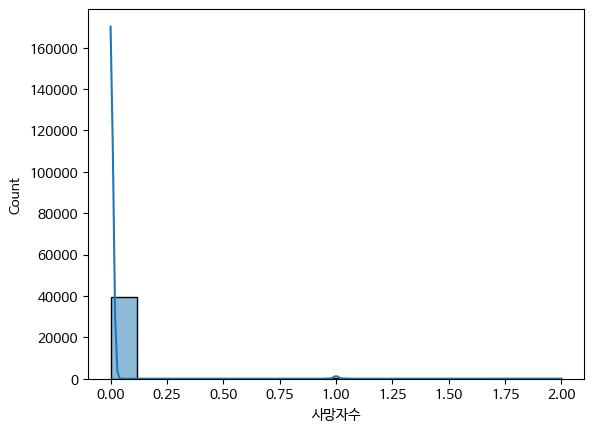

In [ ]:
sns.histplot(df_train['사망자수'], kde=True)
plt.show()

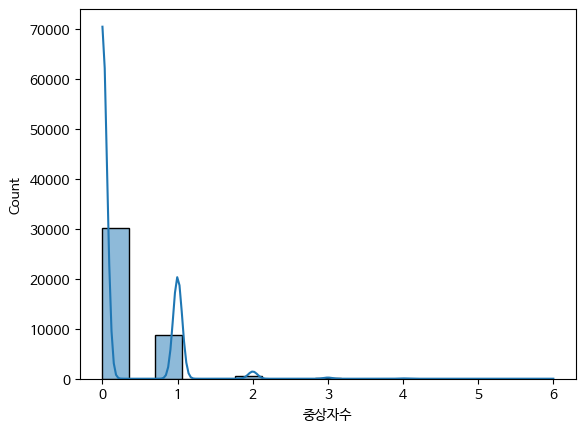

In [ ]:
sns.histplot(df_train['중상자수'], kde=True)
plt.show()

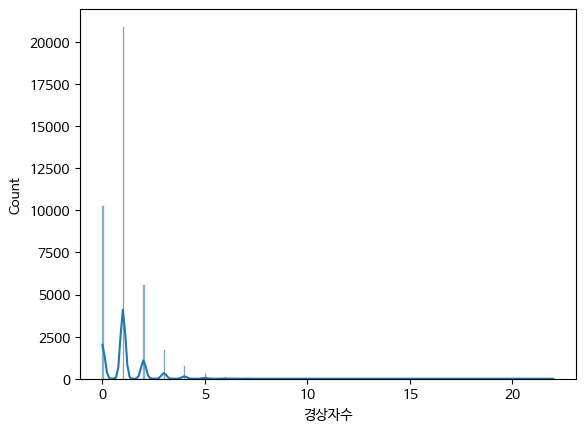

In [ ]:
sns.histplot(df_train['경상자수'], kde=True)
plt.show()

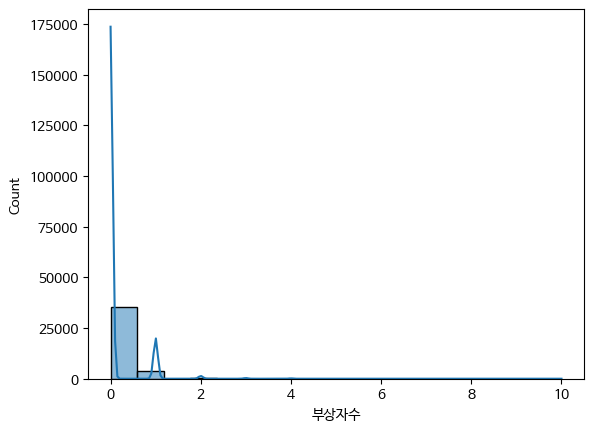

In [ ]:
sns.histplot(df_train['부상자수'], kde=True)
plt.show()

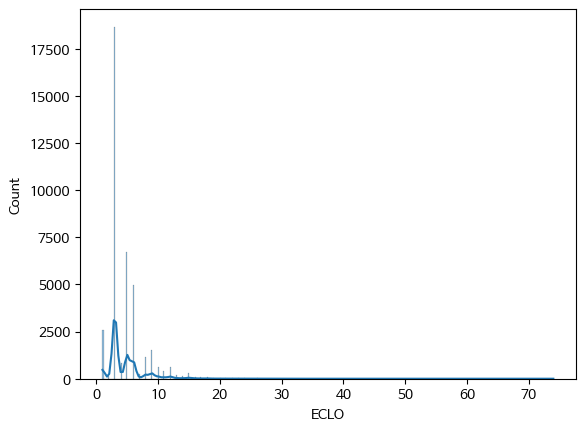

In [ ]:
sns.histplot(df_train['ECLO'], kde=True)
plt.show()

## 시계열 형태로 표현
- `ECLO` 0 이상의 값들만 관측
- 매끄러운 형태로 표현하기 위한 interpolation + imputation 필요

In [ ]:
from datetime import datetime

In [ ]:
df_train['사고일시'] = pd.to_datetime(df_train['사고일시'])

In [ ]:
df_by_time = df_train.sort_values('사고일시')[['사고일시','ECLO']]

In [ ]:
df_by_time = df_by_time[df_by_time['ECLO']>0]

In [ ]:
df_by_time

,사고일시,ECLO
0,2019-01-01 00:00:00,5
1,2019-01-01 00:00:00,3
2,2019-01-01 01:00:00,3
3,2019-01-01 02:00:00,5
4,2019-01-01 04:00:00,3
...,...,...
39605,2021-12-31 19:00:00,3
39603,2021-12-31 19:00:00,3
39606,2021-12-31 21:00:00,10
39607,2021-12-31 22:00:00,3


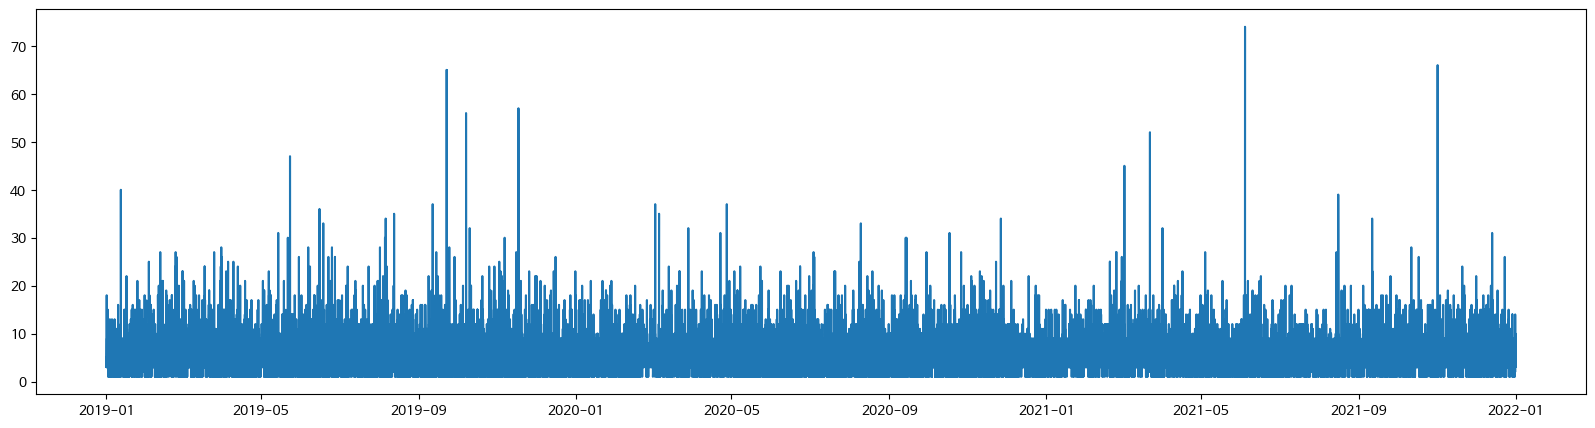

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df_by_time['사고일시'],df_by_time['ECLO'])
plt.show()

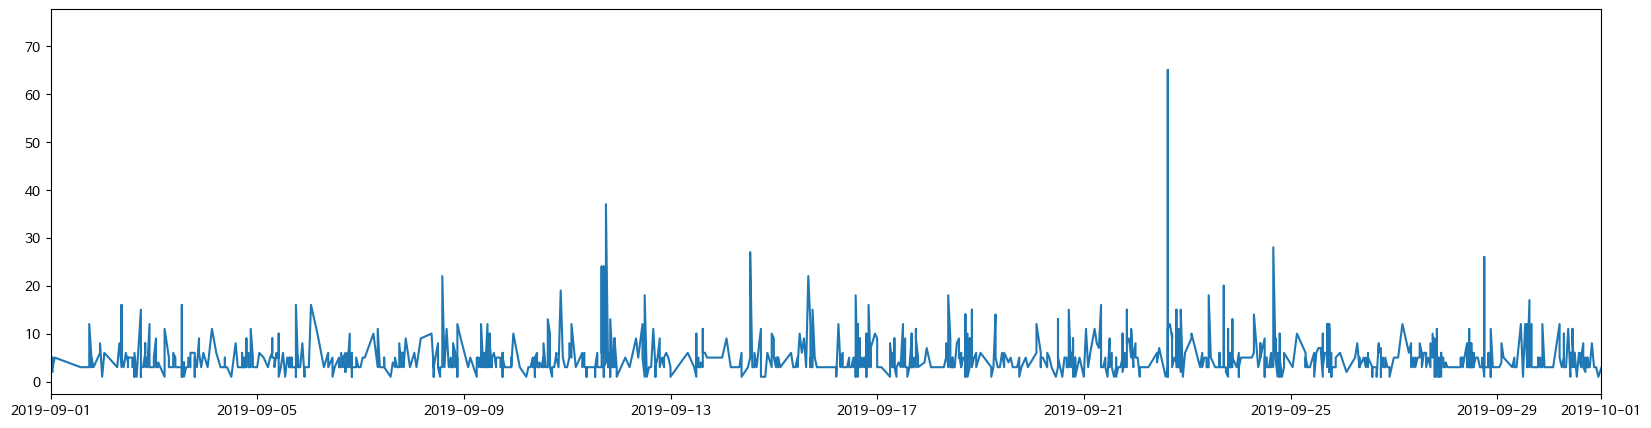

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df_by_time['사고일시'],df_by_time['ECLO'])
plt.xlim(left=datetime(year=2019,month=9,day=1),right=datetime(year=2019,month=10,day=1))
plt.show()

## 사망자, 중상자, 경상자, 부상자별 분포 확인
- 먼저 ECLO가 사망자, 중상자, 경상자, 부상자를 표현하는 지표이기 때문에 이는 나중에 하기로 한다.

<Axes: >

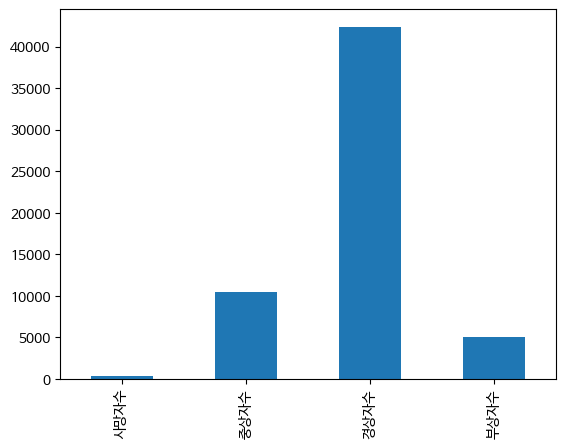

In [ ]:
df_train[['사망자수','중상자수','경상자수','부상자수']].sum().plot(kind='bar')

In [ ]:
df_train_temp = df_train[list(df_test.columns[2:])+['사망자수','중상자수','경상자수','부상자수','ECLO']]

### 사망자

In [ ]:
df_dead = df_train.copy()
df_dead['사망자존재여부'] = (df_dead['사망자수'] > 0).astype(int)

0    39309
1      300
Name: 사망자존재여부, dtype: int64


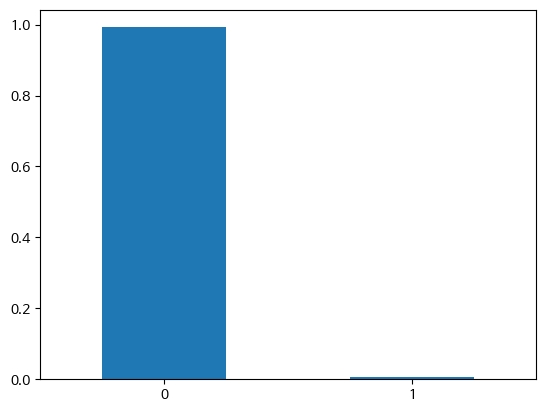

In [ ]:
death_rate = df_dead['사망자존재여부'].value_counts()/df_dead['사망자존재여부'].count()
print(df_dead['사망자존재여부'].value_counts())
death_rate.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

In [ ]:
def barplot_death(feature, y=False, show=True):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].set_title('사망자 없음')
    axes[1].set_title('사망자 있음')
    if not y:
        sns.countplot(x=feature, data=df_dead[df_dead['사망자존재여부']==0], ax=axes[0])
        sns.countplot(x=feature, data=df_dead[df_dead['사망자존재여부']==1], ax=axes[1])
    else:
        sns.countplot(y=feature, data=df_dead[df_dead['사망자존재여부']==0], ax=axes[0])
        sns.countplot(y=feature, data=df_dead[df_dead['사망자존재여부']==1], ax=axes[1])
    if show:
        plt.show()
    else:
        return fig, axes

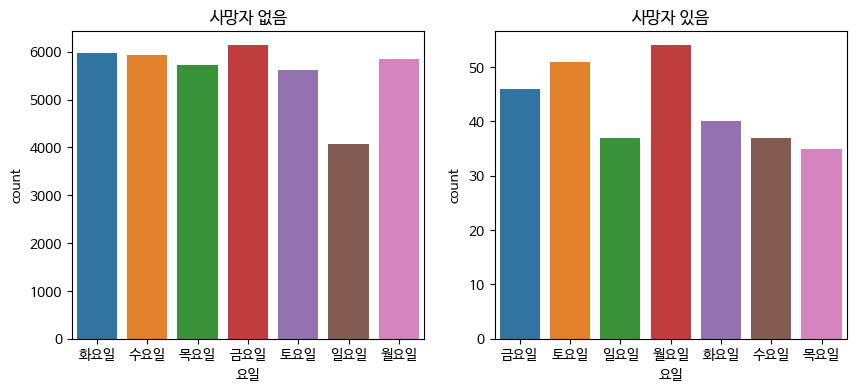

In [ ]:
barplot_death('요일')

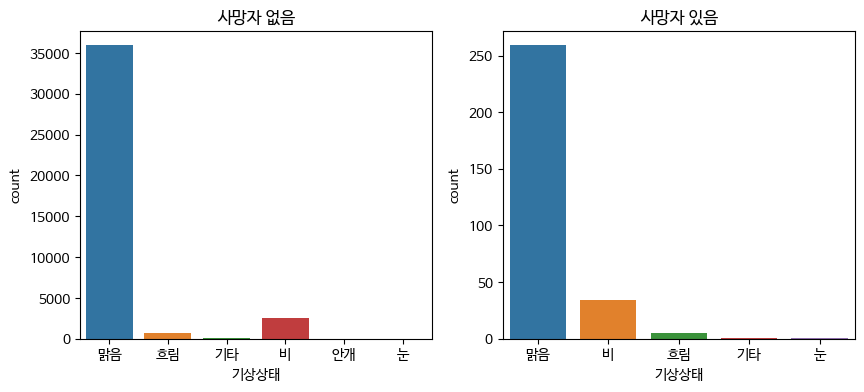

In [ ]:
barplot_death('기상상태')

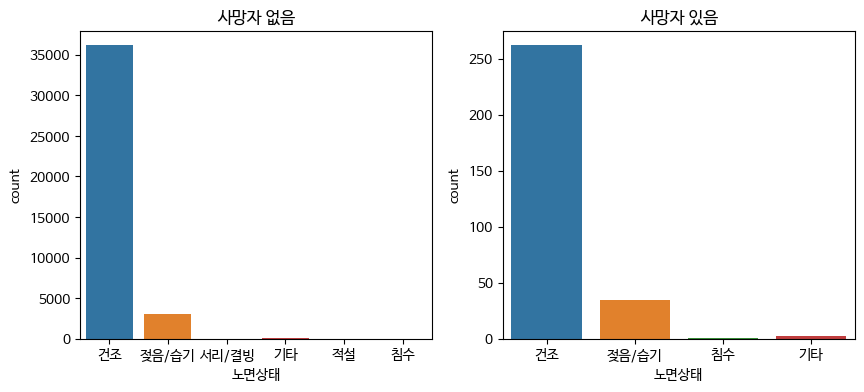

In [ ]:
barplot_death('노면상태')

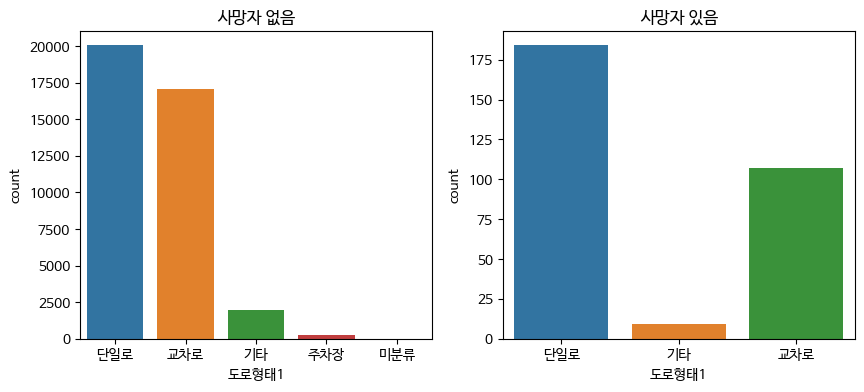

In [ ]:
barplot_death('도로형태1')

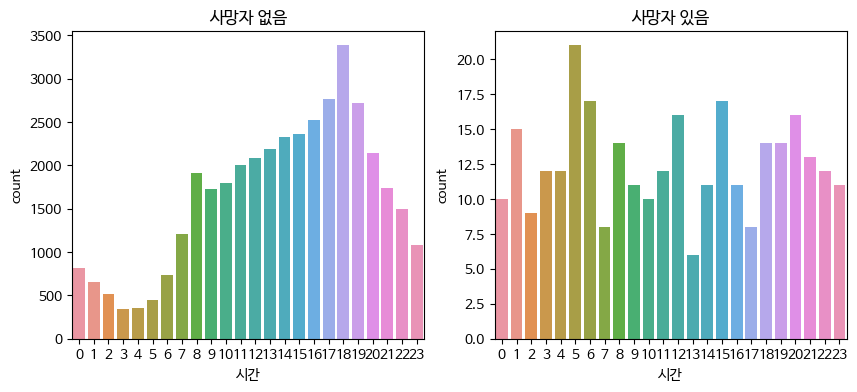

In [ ]:
barplot_death('시간')

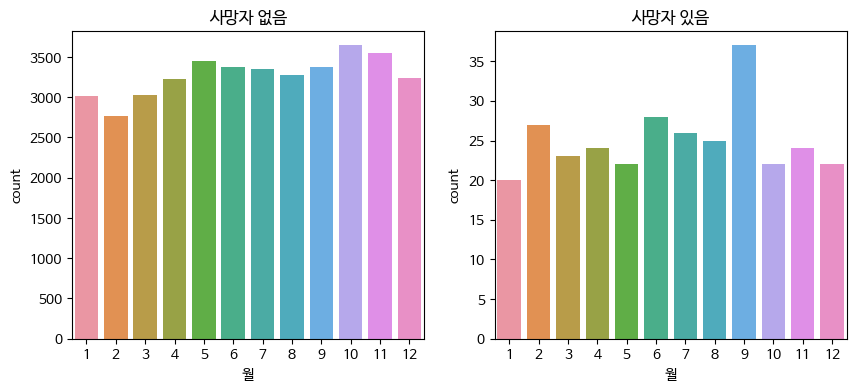

In [ ]:
barplot_death('월')

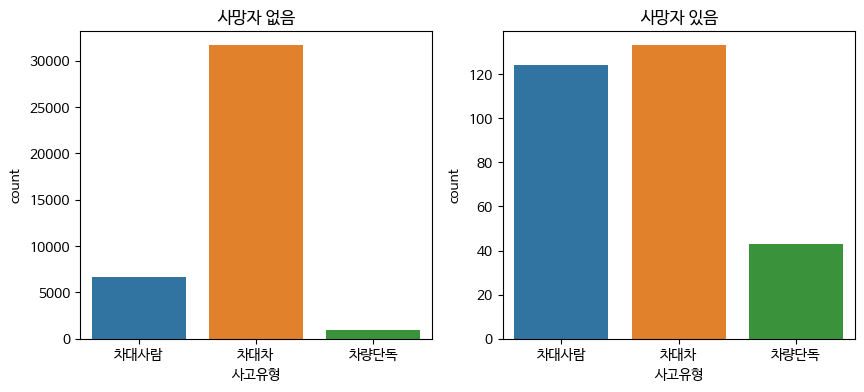

In [ ]:
barplot_death('사고유형')

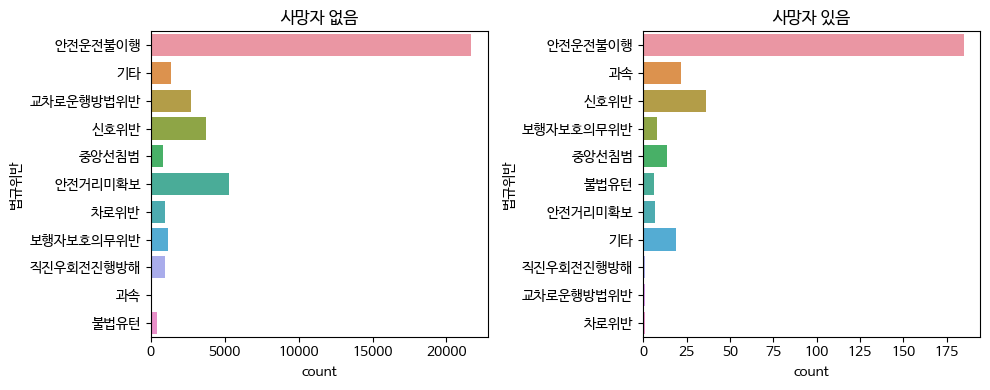

In [ ]:
fig, axes = barplot_death('법규위반', y=True, show=False)
fig.tight_layout()
plt.show()

In [ ]:
df_train.columns

Index(['ID', '사고일시', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',
       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',
       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',
       'ECLO', '연', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2'],
      dtype='object')

## ECLO

In [ ]:
df_train_temp

,요일,기상상태,노면상태,사고유형,연,월,일,시간,월일,구,동,도로형태1,도로형태2,ECLO
0,화요일,맑음,건조,차대사람,2019,1,1,0,0101,중구,대신동,단일로,기타,5
1,화요일,흐림,건조,차대사람,2019,1,1,0,0101,달서구,감삼동,단일로,기타,3
2,화요일,맑음,건조,차대사람,2019,1,1,1,0101,수성구,두산동,단일로,기타,3
3,화요일,맑음,건조,차대차,2019,1,1,2,0101,북구,복현동,단일로,기타,5
4,화요일,맑음,건조,차대차,2019,1,1,4,0101,동구,신암동,단일로,기타,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,금요일,맑음,건조,차대차,2021,12,31,19,1231,수성구,수성동3가,교차로,교차로안,3
39605,금요일,맑음,건조,차대차,2021,12,31,19,1231,달서구,상인동,단일로,기타,3
39606,금요일,맑음,건조,차대차,2021,12,31,21,1231,달서구,월성동,교차로,교차로안,10
39607,금요일,맑음,건조,차대차,2021,12,31,22,1231,달서구,장동,기타,기타,3


In [ ]:
df_train_temp = df_train[list(df_test.columns[2:])+['ECLO']]

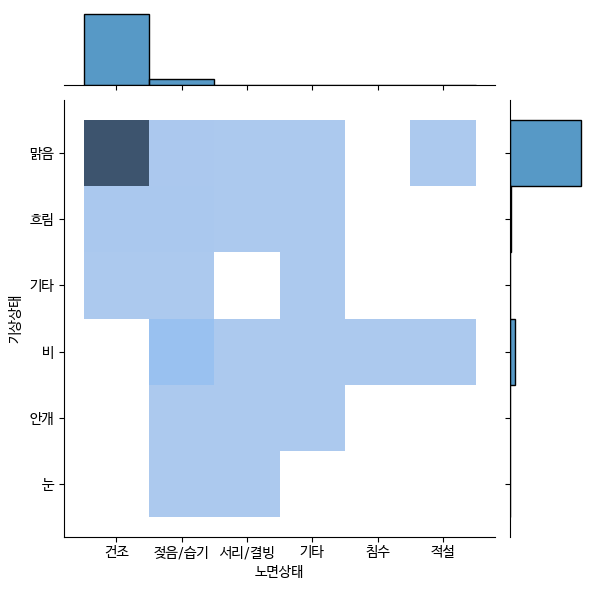

In [ ]:
sns.jointplot(x='노면상태',y='기상상태',data=df_train_temp, kind='hist')

<Axes: xlabel='기상상태', ylabel='ECLO'>

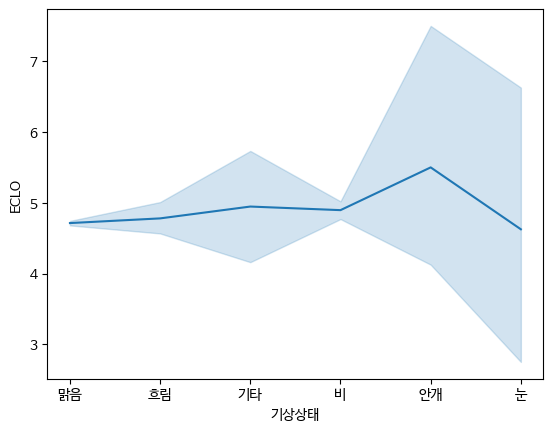

In [ ]:
sns.lineplot(x='기상상태', y='ECLO', data=df_train_temp)

<Axes: xlabel='노면상태', ylabel='ECLO'>

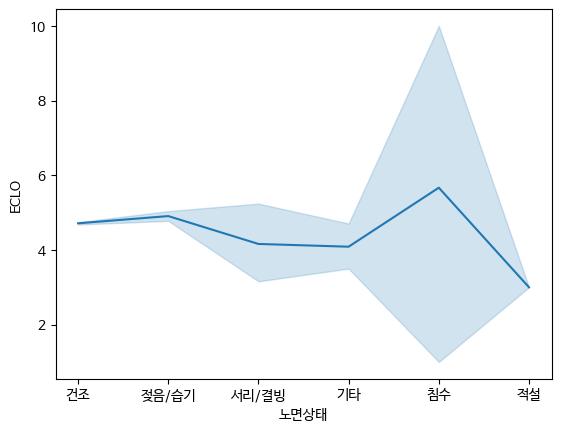

In [ ]:
sns.lineplot(x='노면상태', y='ECLO', data=df_train_temp)

<Axes: xlabel='요일', ylabel='ECLO'>

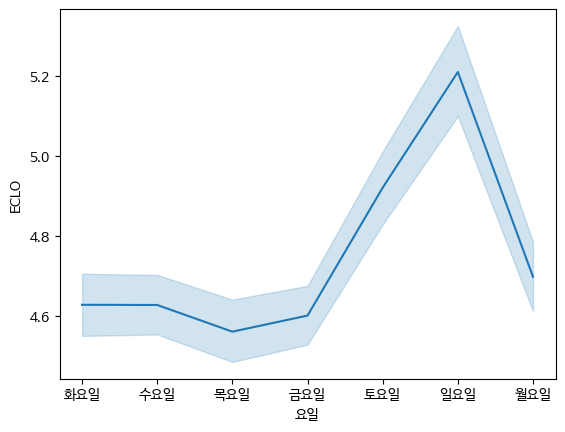

In [ ]:
sns.lineplot(x='요일', y='ECLO', data=df_train_temp)

<Axes: xlabel='사고유형', ylabel='ECLO'>

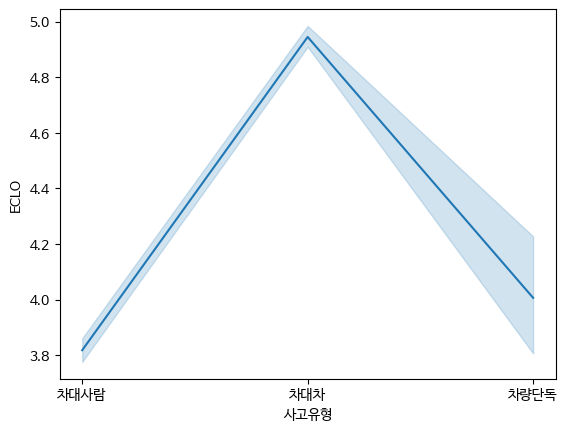

In [ ]:
sns.lineplot(x='사고유형', y='ECLO', data=df_train_temp)

<Axes: xlabel='월일', ylabel='ECLO'>

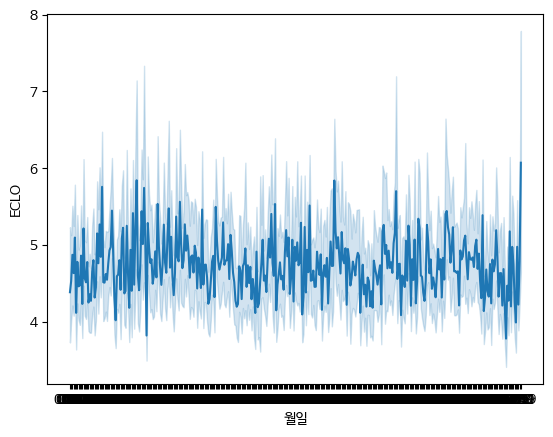

In [ ]:
sns.lineplot(x='월일', y='ECLO', data=df_train_temp)

<Axes: xlabel='월', ylabel='ECLO'>

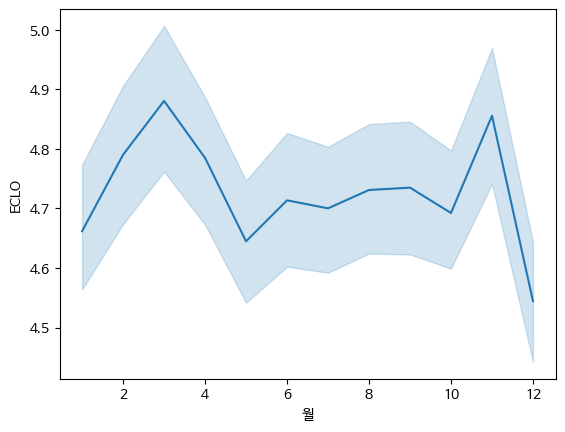

In [ ]:
sns.lineplot(x='월', y='ECLO', data=df_train_temp)

<Axes: xlabel='시간', ylabel='ECLO'>

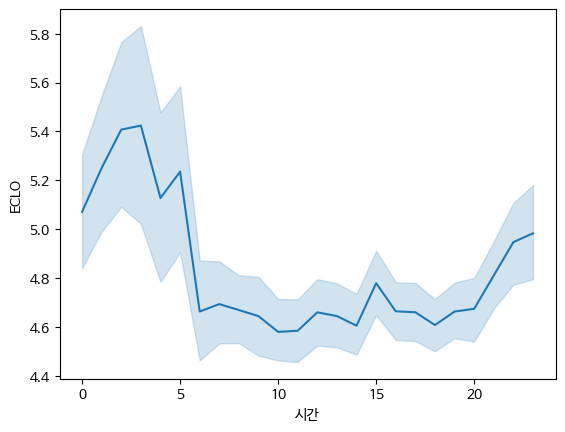

In [ ]:
sns.lineplot(x='시간', y='ECLO', data=df_train_temp)

<Axes: xlabel='구', ylabel='ECLO'>

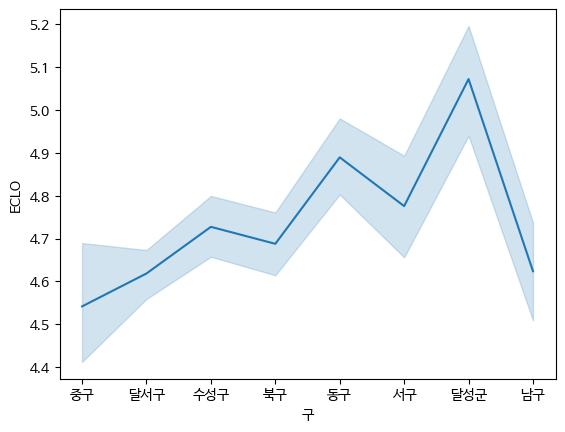

In [ ]:
sns.lineplot(x='구', y='ECLO', data=df_train_temp)

<Axes: xlabel='동', ylabel='ECLO'>

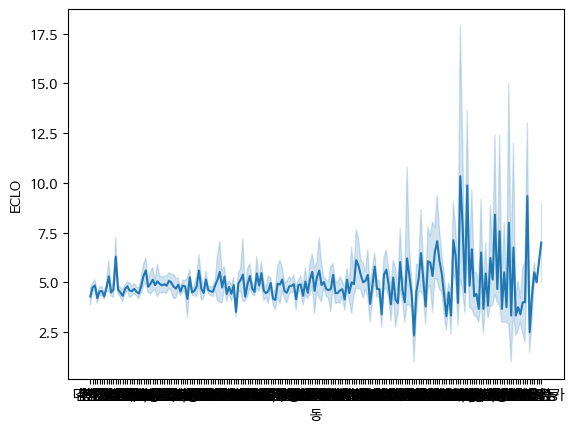

In [ ]:
sns.lineplot(x='동', y='ECLO', data=df_train_temp)

<Axes: xlabel='도로형태1', ylabel='ECLO'>

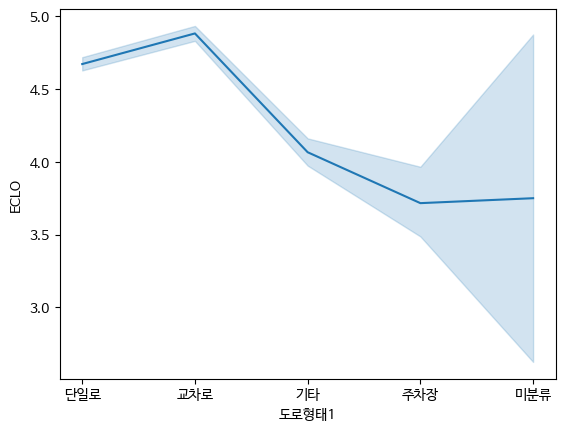

In [ ]:
sns.lineplot(x='도로형태1', y='ECLO', data=df_train_temp)

<Axes: xlabel='도로형태2', ylabel='ECLO'>

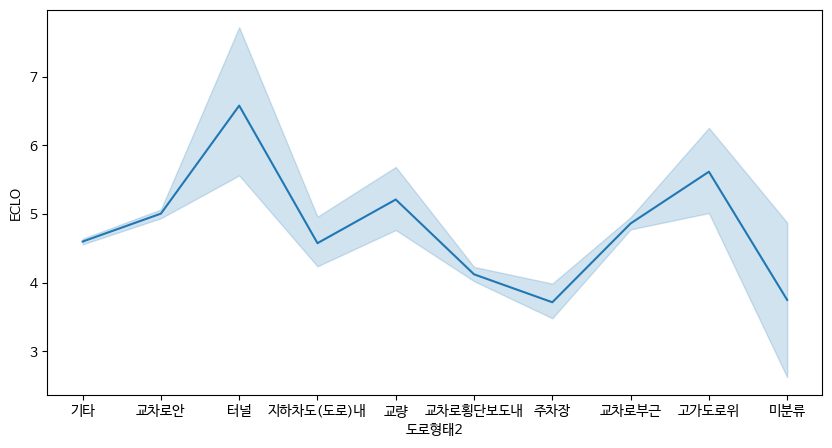

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x='도로형태2', y='ECLO', data=df_train_temp)

## Temp

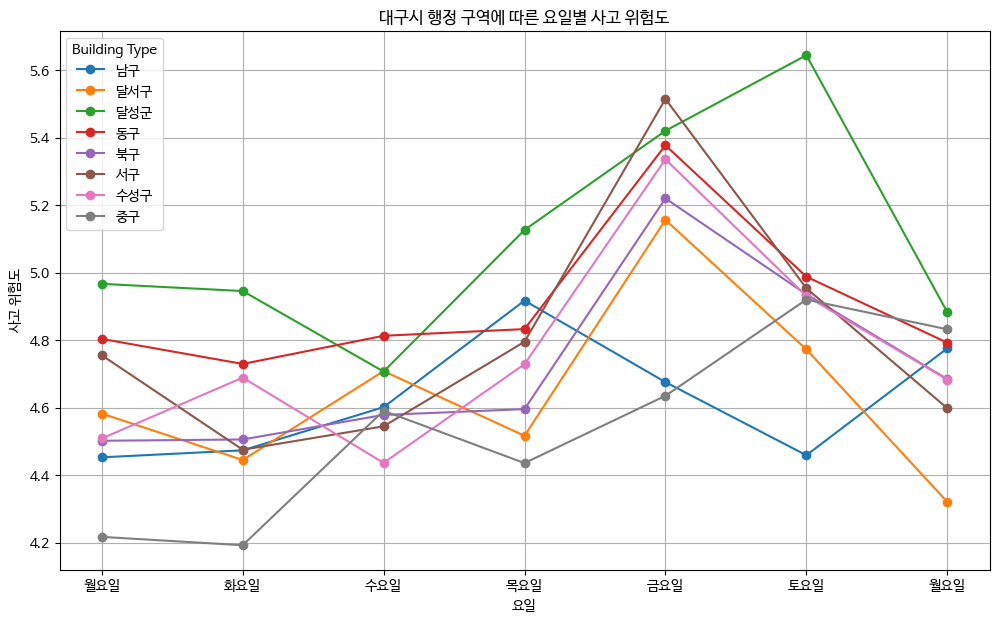

In [ ]:
weekday_gu_stats = df_train.groupby(['요일','구'])['ECLO'].mean().reset_index()

plt.figure(figsize=(12, 7))

for gu_name in weekday_gu_stats['구'].unique():
    subset = weekday_gu_stats[weekday_gu_stats['구'] == gu_name]
    plt.plot(subset['요일'], subset['ECLO'], marker='o', label=gu_name)

plt.xticks(ticks=range(7), labels=['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '월요일'])
plt.xlabel('요일')
plt.ylabel('사고 위험도')
plt.title('대구시 행정 구역에 따른 요일별 사고 위험도')
plt.legend(title='Building Type')
plt.grid(True)
plt.show()

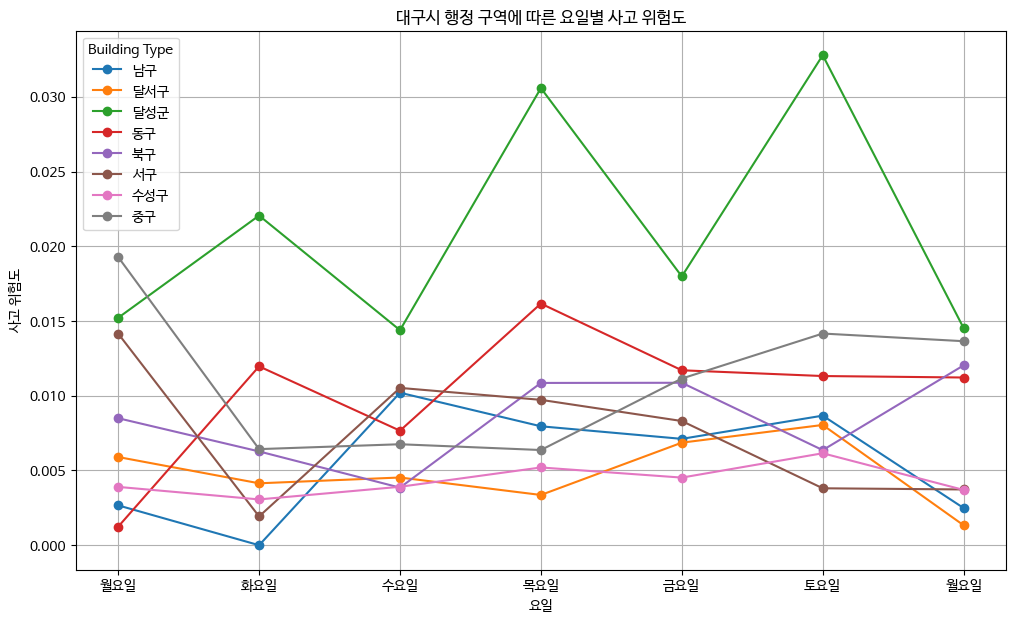

In [ ]:
weekday_gu_stats = df_train.groupby(['요일','구'])['사망자수'].mean().reset_index()

plt.figure(figsize=(12, 7))

for gu_name in weekday_gu_stats['구'].unique():
    subset = weekday_gu_stats[weekday_gu_stats['구'] == gu_name]
    plt.plot(subset['요일'], subset['사망자수'], marker='o', label=gu_name)

plt.xticks(ticks=range(7), labels=['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '월요일'])
plt.xlabel('요일')
plt.ylabel('사고 위험도')
plt.title('대구시 행정 구역에 따른 요일별 사고 위험도')
plt.legend(title='Building Type')
plt.grid(True)
plt.show()

## Empty

# Data Preprocess & Modeling

In [26]:
X_train_df = df_train[df_test.columns]
y_train_df = df_train['ECLO']
X_test_df = df_test.copy()

In [215]:
X_train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '구', '동', '설치개수', '주차구획수',
       '주차기본시간', '주차기본요금', '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금',
       '월정기권요금', '위도', '경도', '공영', '민영', '노상', '노외', '1', '2', '3', '평일운영시간',
       '토요일운영시간', '공휴일운영시간', '무료', '유료', '혼합', '주차장수', 'camera_all',
       'camera_1', 'camera_2', 'camera_4', 'camera_99', 'protect_all',
       'protect_1', 'protect_2', 'protect_99', 'speed_limit', 'speed_min',
       'speed_max', '보호구역도로폭_카테고리', '어린이보호구역 개수', '어보구CCTV설치비율', '하차', '승차',
       'count', 'occrrnc_cnt_sum', 'caslt_cnt_sum', 'dth_dnv_cnt_sum',
       'se_dnv_cnt_sum', 'sl_dnv_cnt_sum', 'wnd_dnv_cnt_sum', 'total', '연',
       '월', '일', '시간', '월일'],
      dtype='object')

In [27]:
drop_cols = ['ID','연','월','일','주차기본시간','주차기본요금','추가단위시간','추가단위요금','1일주차권요금적용시간','1일주차권요금','월정기권요금','위도','경도','protect_1']

X_train_df = X_train_df.drop(columns=drop_cols)
X_test_df = X_test_df.drop(columns=drop_cols)

In [217]:
X_train_df.columns == X_test_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [28]:
sc = MinMaxScaler()
numeric_cols = X_train_df.select_dtypes(float).columns

X_train_df[numeric_cols] = sc.fit_transform(X_train_df.select_dtypes(float))
X_test_df[numeric_cols] = sc.transform(X_test_df.select_dtypes(float))

In [29]:
X_train_df.isna().sum()

요일                    0
기상상태                  0
도로형태                  0
노면상태                  0
사고유형                  0
구                     0
동                     0
설치개수               2799
주차구획수              6543
공영                 6543
민영                 6543
노상                 6543
노외                 6543
1                  6543
2                  6543
3                  6543
평일운영시간             6543
토요일운영시간            6543
공휴일운영시간            6543
무료                 6543
유료                 6543
혼합                 6543
주차장수               6543
camera_all         1572
camera_1           1572
camera_2           1572
camera_4           1572
camera_99          1572
protect_all        1572
protect_2          1572
protect_99         1572
speed_limit        2512
speed_min          2512
speed_max          2512
보호구역도로폭_카테고리          0
어린이보호구역 개수            0
어보구CCTV설치비율           0
하차                    0
승차                    0
count              7819
occrrnc_cnt_sum    7819
caslt_cnt_sum   

**NaN 값 채우기 기준**

`주차장`
- 주차구획수, 주차장수 -> mean
- 공영, 민영 -> 0
- 노상, 노외 -> 0
- 1, 2, 3 (급지) -> 0
- 평일운영시간 -> mean
- 토요일운영시간, 공휴일운영시간 -> 0
- 무료, 유료 -> 0

`CCTV`
- speed_limit, min, max -> most_frequent
- 나머지 -> 0

`보안등`
- ?

`보호구역`
- ?

In [220]:
X_train_df.select_dtypes('object').columns

Index(['요일', '기상상태', '도로형태', '노면상태', '사고유형', '구', '동', '월일'], dtype='object')

In [30]:
le_cols = ['요일', '기상상태', '도로형태', '노면상태', '사고유형', '구', '동']
le = LabelEncoder()

for col in le_cols:
    X_train_df[col] = le.fit_transform(X_train_df[col])
    X_test_df[col] = le.transform(X_test_df[col])

In [138]:
oc = OneHotEncoder()

oc.fit_transform(X_train_df[X_train_df.select_dtypes('object').columns])

<39609x237 sparse matrix of type '<class 'numpy.float64'>'
	with 277263 stored elements in Compressed Sparse Row format>

In [ ]:
pca = PCA()

''' = pca.fit_transform(''')
''' = pca.transform(''')

In [31]:
mean_fill_cols = ['주차구획수','주차장수','평일운영시간']

X_train_df[mean_fill_cols] = X_train_df[mean_fill_cols].fillna(X_train_df[mean_fill_cols].mean())
X_test_df[mean_fill_cols] = X_test_df[mean_fill_cols].fillna(X_train_df[mean_fill_cols].mean())

In [32]:
mode_fill_cols = ['speed_limit','speed_min','speed_max']

X_train_df[mode_fill_cols] = X_train_df[mode_fill_cols].fillna(X_train_df[mode_fill_cols].mode())
X_test_df[mode_fill_cols] = X_test_df[mode_fill_cols].fillna(X_train_df[mode_fill_cols].mode())

In [33]:
X_train_df.fillna(0, inplace=True)
X_test_df.fillna(0, inplace=True)

In [208]:
X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values

In [209]:
y_train = np.log1p(y_train)

In [210]:
lgbm = lgb.LGBMRegressor(n_estimators=1000)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 39609, number of used features: 50
[LightGBM] [Info] Start training from score 1.633697


LGBMRegressor(n_estimators=1000)

In [211]:
fi_df = pd.DataFrame(lgbm.feature_importances_/np.sum(lgbm.feature_importances_),
             index=X_train_df.columns).sort_values(0)

<Axes: xlabel='0'>

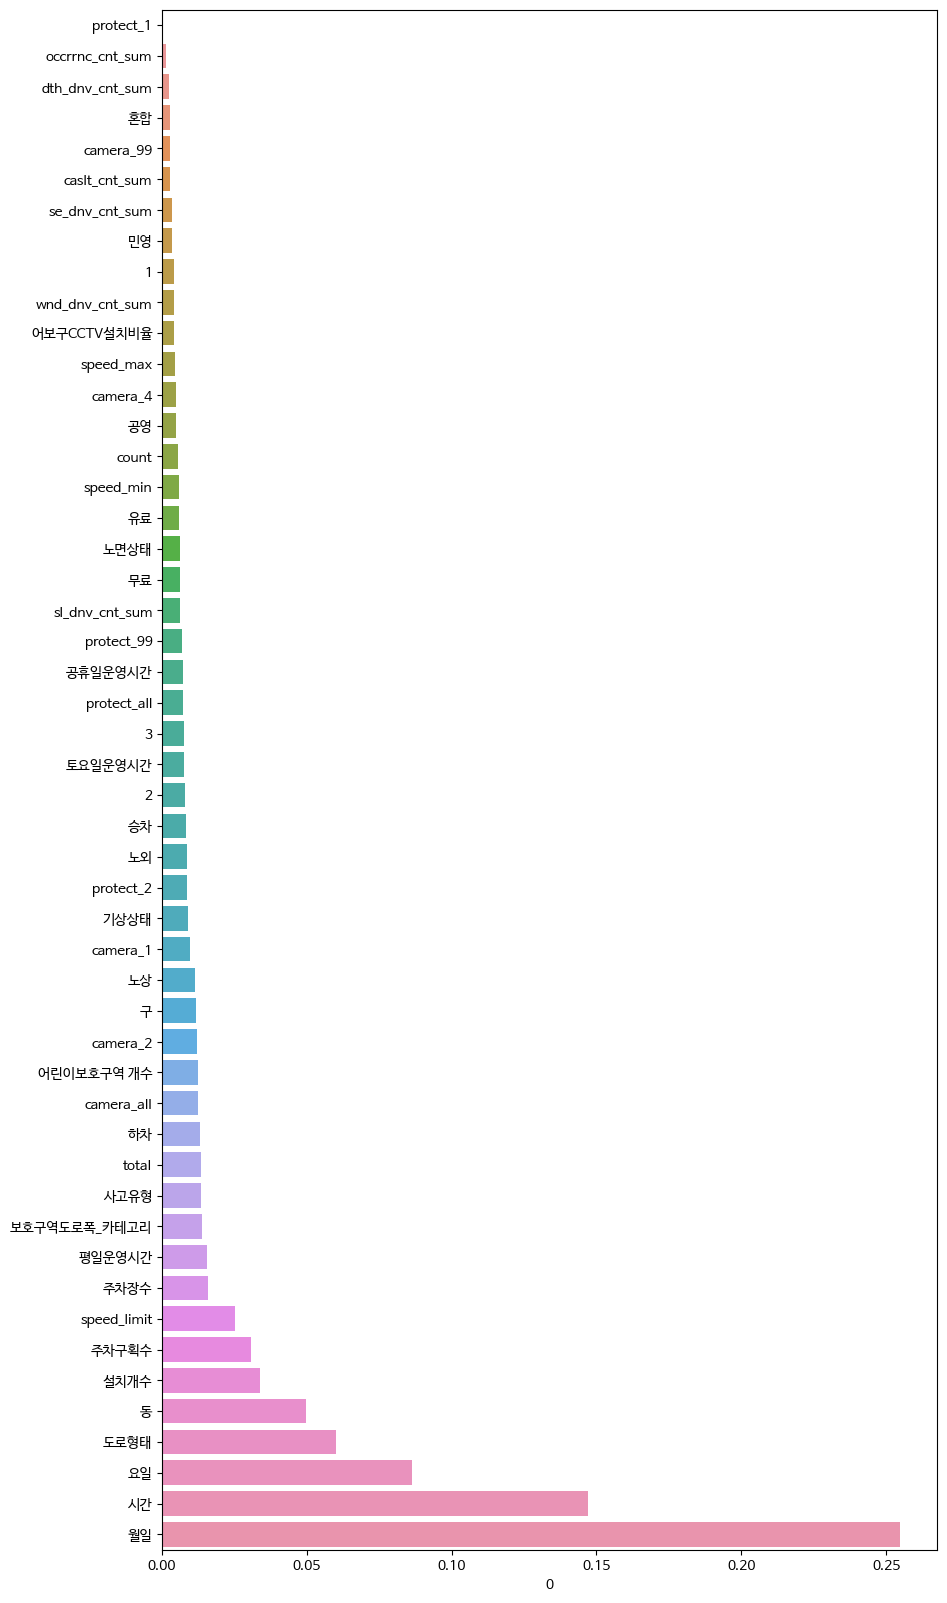

In [212]:
plt.figure(figsize=(10,20))
sns.barplot(y=fi_df.index,x=0,data=fi_df)

In [ ]:
y_pred = lgbm.predict(X_test)
y_pred = np.exp(y_pred) + 1
y_pred = np.round(y_pred,0)
print(y_pred)

[6. 6. 7. ... 6. 7. 7.]


In [ ]:
sub = pd.read_csv('./open/sample_submission.csv')
sub['ECLO'] = y_pred
sub

,ID,ECLO
0,ACCIDENT_39609,6.0
1,ACCIDENT_39610,6.0
2,ACCIDENT_39611,7.0
3,ACCIDENT_39612,6.0
4,ACCIDENT_39613,6.0
...,...,...
10958,ACCIDENT_50567,8.0
10959,ACCIDENT_50568,6.0
10960,ACCIDENT_50569,6.0
10961,ACCIDENT_50570,7.0


In [ ]:
sub.to_csv('./submit/lgbm_base.csv',index=False)

# 다른 데이터

In [ ]:
df_cctv = pd.read_csv('./open/external_open/대구 cctv 정보.csv')

In [ ]:
df_countrywide = pd.read_csv('./open/external_open/countrywide_accident.csv')

In [ ]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

df_countrywide[['연', '월', '일', '시간']] = df_countrywide['사고일시'].str.extract(time_pattern)
df_countrywide['월일'] = df_countrywide['월'] + df_countrywide['일']
df_countrywide[['연', '월', '일', '시간']] = df_countrywide[['연', '월', '일', '시간']].apply(pd.to_numeric)

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'

df_countrywide[['도시', '구', '동']] = df_countrywide['시군구'].str.extract(location_pattern)
df_countrywide = df_countrywide.drop(columns=['시군구'])

In [ ]:
road_pattern = r'(.+) - (.+)'

df_countrywide[['도로형태1', '도로형태2']] = df_countrywide['도로형태'].str.extract(road_pattern)
df_countrywide = df_countrywide.drop(columns=['도로형태'])

In [ ]:
df_countrywide.loc[:,'가해운전자 연령'][df_countrywide['가해운전자 연령']=='미분류'] = [np.nan] * len(df_countrywide[df_countrywide['가해운전자 연령']=='미분류'])
df_countrywide.loc[:,'피해운전자 연령'][df_countrywide['피해운전자 연령']=='미분류'] = [np.nan] * len(df_countrywide[df_countrywide['피해운전자 연령']=='미분류'])
df_countrywide.loc[:,'가해운전자 연령'][~df_countrywide['가해운전자 연령'].isna()] = df_countrywide.loc[:,'가해운전자 연령'][~df_countrywide['가해운전자 연령'].isna()].str.replace('세','').str.replace('이상','').astype(int)
df_countrywide.loc[:,'피해운전자 연령'][~df_countrywide['피해운전자 연령'].isna()] = df_countrywide.loc[:,'피해운전자 연령'][~df_countrywide['피해운전자 연령'].isna()].str.replace('세','').str.replace('이상','').astype(int)

In [ ]:
df_countrywide['도시'].unique()

array(['서울특별시', '경기도', '인천광역시', '전라남도', '충청남도', '광주광역시', '부산광역시', '강원도',
       '울산광역시', '전라북도', '경상남도', '경상북도', '충청북도', '대전광역시', '제주특별자치도',
       '세종특별자치시', '미분류', nan], dtype=object)

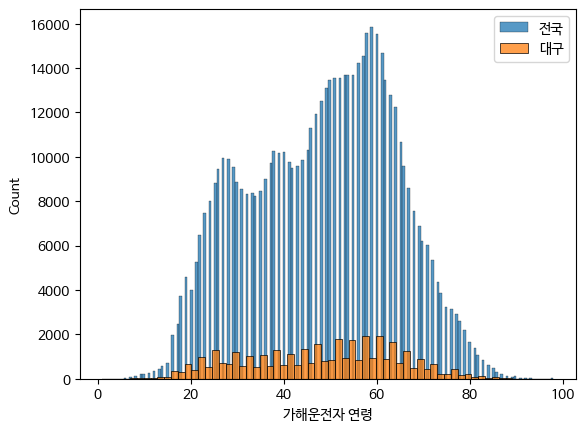

In [ ]:
sns.histplot(x='가해운전자 연령',data=df_countrywide,label='전국')
sns.histplot(x='가해운전자 연령',data=df_train,label='대구')

plt.legend()
plt.show()

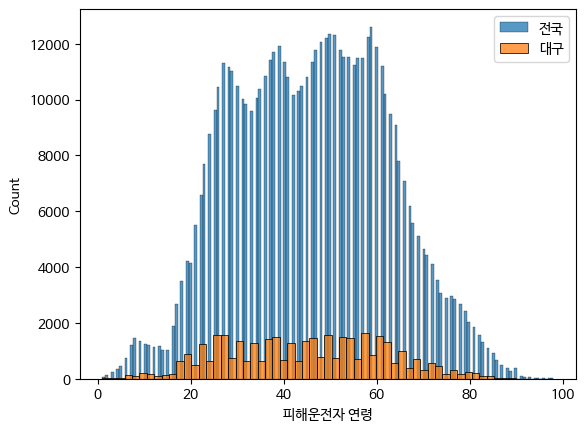

In [ ]:
sns.histplot(x='피해운전자 연령',data=df_countrywide,label='전국')
sns.histplot(x='피해운전자 연령',data=df_train,label='대구')

plt.legend()
plt.show()

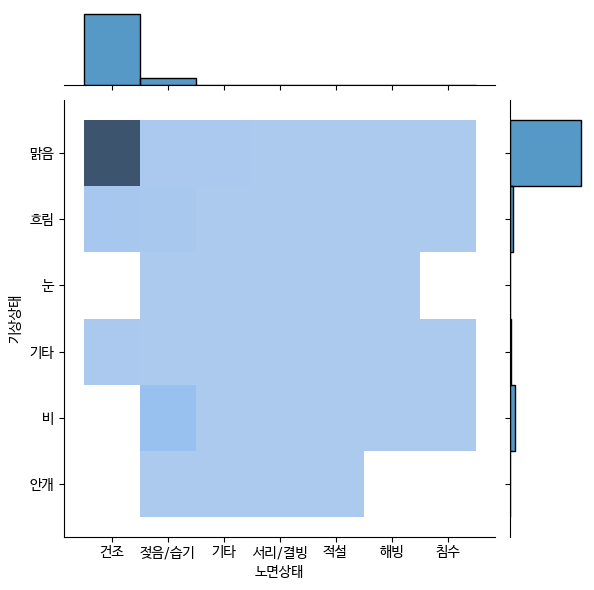

In [ ]:
sns.jointplot(x='노면상태',y='기상상태',data=df_countrywide, kind='hist')

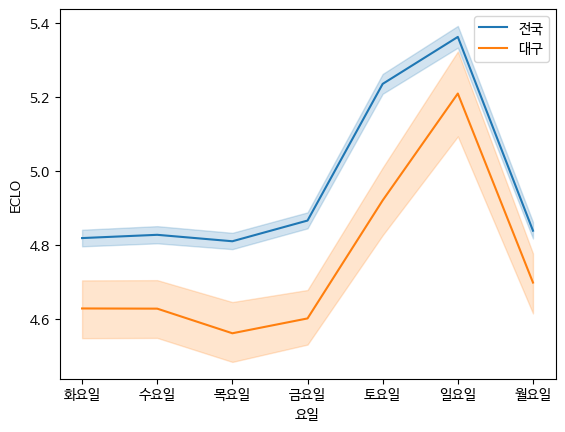

In [ ]:
sns.lineplot(x='요일',y='ECLO',data=df_countrywide,label='전국')
sns.lineplot(x='요일',y='ECLO',data=df_train,label='대구')

plt.legend()
plt.show()

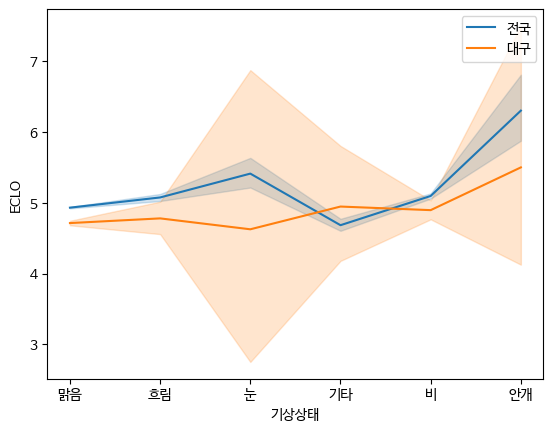

In [ ]:
x = '기상상태'

sns.lineplot(x=x,y='ECLO',data=df_countrywide,label='전국')
sns.lineplot(x=x,y='ECLO',data=df_train,label='대구')

plt.legend()
plt.show()

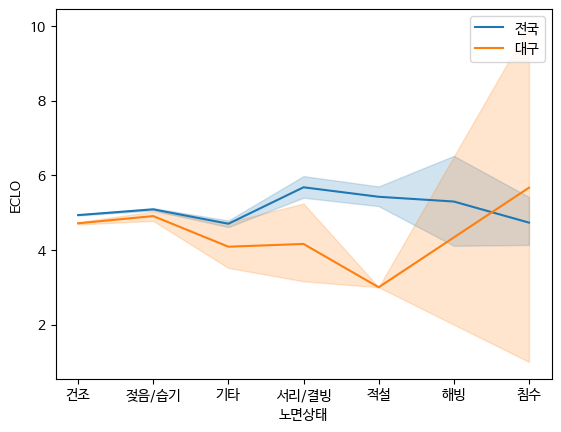

In [ ]:
x = '노면상태'

sns.lineplot(x=x,y='ECLO',data=df_countrywide,label='전국')
sns.lineplot(x=x,y='ECLO',data=df_train,label='대구')

plt.legend()
plt.show()

In [ ]:
df_countrywide.columns

Index(['ID', '사고일시', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',
       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',
       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',
       'ECLO', '연', '월', '일', '시간', '월일', '도시', '구', '동', '도로형태1', '도로형태2'],
      dtype='object')

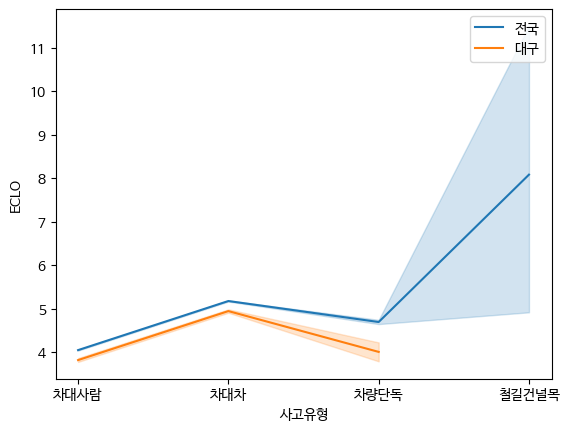

In [ ]:
x = '사고유형'

sns.lineplot(x=x,y='ECLO',data=df_countrywide,label='전국')
sns.lineplot(x=x,y='ECLO',data=df_train,label='대구')

plt.legend()
plt.show()

In [ ]:
df_train['법규위반'].value_counts()

안전운전불이행      21876
안전거리미확보       5277
신호위반          3786
교차로운행방법위반     2750
기타            1396
보행자보호의무위반     1154
직진우회전진행방해      980
차로위반           949
중앙선침범          881
불법유턴           427
과속             133
Name: 법규위반, dtype: int64

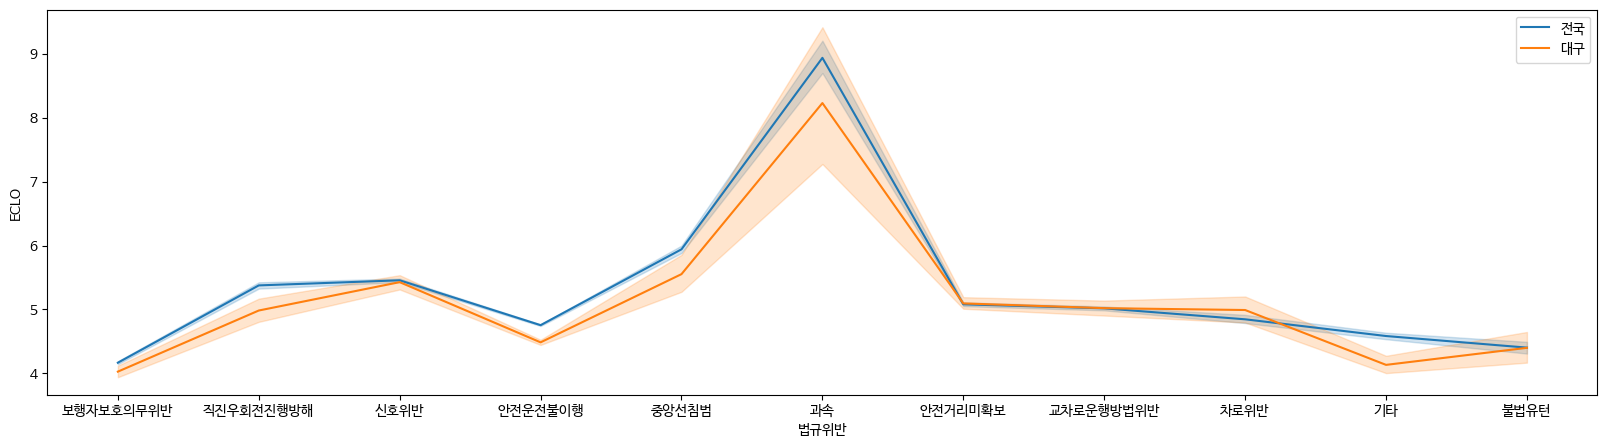

In [ ]:
plt.figure(figsize=(20,5))
x = '법규위반'

sns.lineplot(x=x,y='ECLO',data=df_countrywide,label='전국')
sns.lineplot(x=x,y='ECLO',data=df_train,label='대구')

plt.legend()
plt.show()

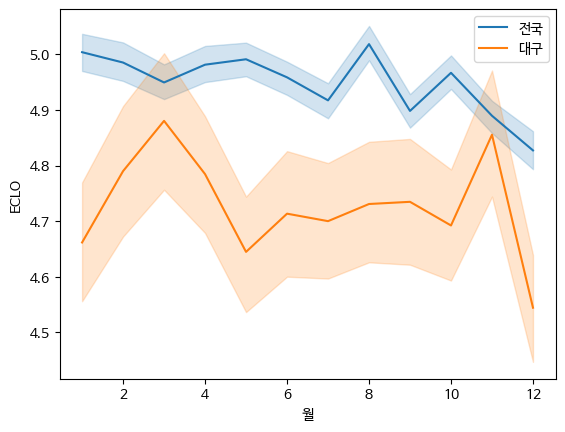

In [ ]:
x = '월'

sns.lineplot(x=x,y='ECLO',data=df_countrywide,label='전국')
sns.lineplot(x=x,y='ECLO',data=df_train,label='대구')

plt.legend()
plt.show()

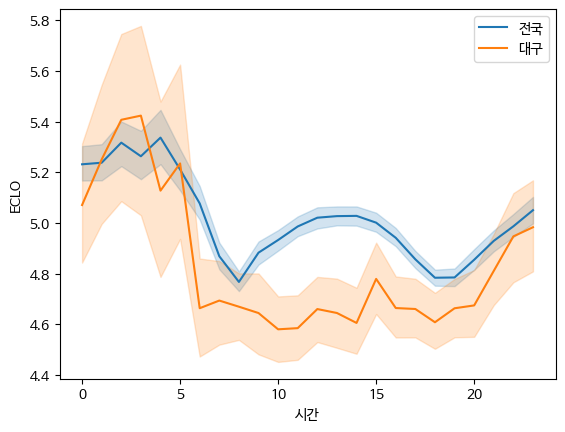

In [ ]:
x = '시간'

sns.lineplot(x=x,y='ECLO',data=df_countrywide,label='전국')
sns.lineplot(x=x,y='ECLO',data=df_train,label='대구')

plt.legend()
plt.show()

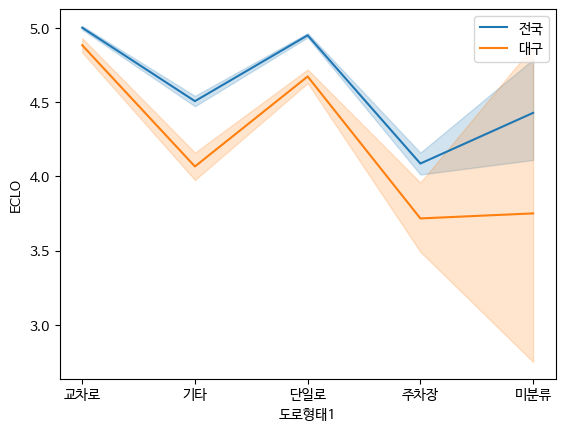

In [ ]:
x = '도로형태1'

sns.lineplot(x=x,y='ECLO',data=df_countrywide,label='전국')
sns.lineplot(x=x,y='ECLO',data=df_train,label='대구')

plt.legend()
plt.show()

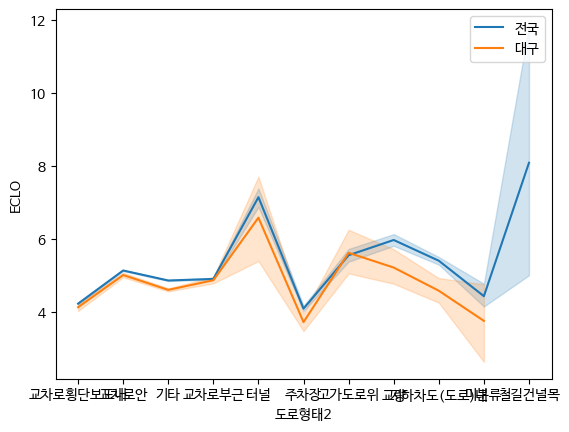

In [ ]:
x = '도로형태2'

sns.lineplot(x=x,y='ECLO',data=df_countrywide,label='전국')
sns.lineplot(x=x,y='ECLO',data=df_train,label='대구')

plt.legend()
plt.show()

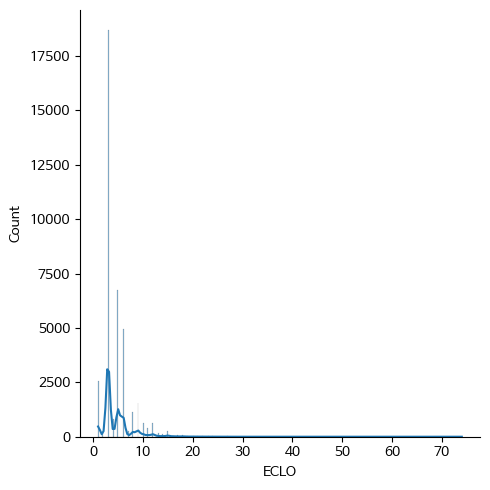

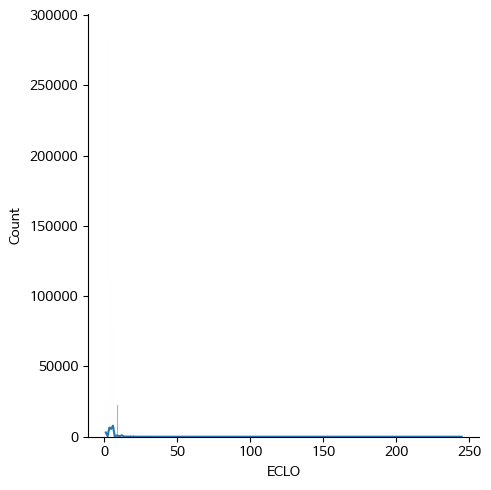

In [ ]:
sns.displot(x='ECLO',
            data=df_train,
            kde=True
            )
sns.displot(x='ECLO',
            data=df_countrywide,
            kde=True
            )

plt.show()

# 주차장

In [ ]:
df_parking = pd.read_csv('./open/external_open/대구 주차장 정보.csv',encoding='euc-kr')

In [ ]:
df_parking['데이터기준일자'].sort_values()

683    2019-06-01
695    2019-06-01
694    2019-06-01
693    2019-06-01
692    2019-06-01
          ...    
130    2020-03-17
129    2020-03-17
128    2020-03-17
138    2020-03-17
164    2020-03-17
Name: 데이터기준일자, Length: 871, dtype: object

In [ ]:
df_parking['소재지지번주소']

0      대구광역시 남구 봉덕동 1002-69
1        대구광역시 남구 봉덕동 687-8
2      대구광역시 남구 대명동 1803-10
3         대구광역시 남구 봉덕동 1256
4        대구광역시 남구 봉덕동 976-5
               ...         
866    대구광역시 중구 동인동1가 330-8
867       대구광역시 중구 수창동 95-1
868       대구광역시 중구 봉산동 38-2
869      대구광역시 중구 삼덕동2가 246
870        대구광역시 중구 동산동 194
Name: 소재지지번주소, Length: 871, dtype: object

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
df_parking[['시','군','구']] = df_parking['소재지지번주소'].str.extract(location_pattern).iloc[:,:3]
df_parking = df_parking.drop(columns='소재지지번주소')

In [ ]:
df_1 = pd.get_dummies(df_parking['주차장구분']).astype(int)
df_1

,공영,민영
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
866,0,1
867,0,1
868,0,1
869,0,1


In [ ]:
df_2 = pd.get_dummies(df_parking['주차장유형']).astype(int)
df_2

,노상,노외
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
866,0,1
867,0,1
868,0,1
869,0,1


In [ ]:
df_3 = pd.get_dummies(df_parking['급지구분']).astype(int)
df_3

,1,2,3
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,1,0,0
...,...,...,...
866,1,0,0
867,1,0,0
868,1,0,0
869,1,0,0


In [ ]:
df_parking = pd.concat([df_parking, df_1, df_2, df_3], axis=1)
df_parking = df_parking.drop(columns=['주차장구분','주차장유형','급지구분'])

In [ ]:
df_parking.columns

Index([    '주차장관리번호',        '주차장명',    '소재지도로명주소',       '주차구획수',
            '부제시행구분',        '운영요일',    '평일운영시작시각',    '평일운영종료시각',
         '토요일운영시작시각',   '토요일운영종료시각',   '공휴일운영시작시각',   '공휴일운영종료시각',
              '요금정보',      '주차기본시간',      '주차기본요금',      '추가단위시간',
            '추가단위요금', '1일주차권요금적용시간',     '1일주차권요금',      '월정기권요금',
              '결제방법',        '특기사항',          '위도',          '경도',
           '데이터기준일자',           '시',           '군',           '구',
                '공영',          '민영',          '노상',          '노외',
                   1,             2,             3],
      dtype='object')

In [ ]:
sr_1 = (pd.to_datetime(df_parking['평일운영종료시각']) - pd.to_datetime(df_parking['평일운영시작시각'])).dt.seconds
sr_2 = (pd.to_datetime(df_parking['토요일운영종료시각']) - pd.to_datetime(df_parking['토요일운영시작시각'])).dt.seconds
sr_3 = (pd.to_datetime(df_parking['공휴일운영종료시각']) - pd.to_datetime(df_parking['공휴일운영시작시각'])).dt.seconds

In [ ]:
df_4 = pd.DataFrame(data=zip(sr_1,sr_2,sr_3),
             columns=['평일운영시간','토요일운영시간','공휴일운영시간'])

In [ ]:
df_parking = pd.concat([df_parking, df_4], axis=1)
df_parking = df_parking.drop(columns=[
    '평일운영종료시각','평일운영시작시각',
    '토요일운영종료시각','토요일운영시작시각',
    '공휴일운영종료시각','공휴일운영시작시각',
    '운영요일'])

In [ ]:
df_5 = pd.get_dummies(df_parking['요금정보']).astype(int)
df_5

,무료,유료,혼합
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
866,0,1,0
867,0,1,0
868,0,1,0
869,0,1,0


In [ ]:
df_parking = pd.concat([df_parking, df_5], axis=1)
df_parking = df_parking.drop(columns=['요금정보'])

In [ ]:
df_parking.columns

Index([    '주차장관리번호',        '주차장명',    '소재지도로명주소',       '주차구획수',
            '부제시행구분',      '주차기본시간',      '주차기본요금',      '추가단위시간',
            '추가단위요금', '1일주차권요금적용시간',     '1일주차권요금',      '월정기권요금',
              '특기사항',          '위도',          '경도',     '데이터기준일자',
                 '시',           '군',           '구',          '공영',
                '민영',          '노상',          '노외',             1,
                   2,             3,      '평일운영시간',     '토요일운영시간',
           '공휴일운영시간',          '무료',          '유료',          '혼합'],
      dtype='object')

In [ ]:
df_parking = df_parking.drop(columns=[
    '주차장관리번호','주차장명','소재지도로명주소',
    '부제시행구분','특기사항','데이터기준일자'])

In [ ]:
df_parking['시군구'] = df_parking['시'] + ' ' + df_parking['군'] +  ' ' + df_parking['구']
df_parking = df_parking.drop(columns=['시','군','구'])

In [ ]:
parking_lots_count = df_parking['시군구'].value_counts()

In [ ]:
df_parking_by_place = df_parking.groupby('시군구').mean()

In [ ]:
df_parking_by_place['주차장수'] = parking_lots_count

In [ ]:
df_parking_by_place['시군구'] = df_parking_by_place.index

In [ ]:
df_parking_by_place.to_csv('./parking_by_place.csv',index=False,encoding='utf-8')

### Before

In [ ]:
df_parking['주차장구분'] = df_parking['주차장구분'].map({'공영':0,'민영':1})

In [ ]:
df_parking['운영요일'] = df_parking['운영요일'].map({'평일+토요일+공휴일':7, '평일':5, '평일+토요일':6})

In [ ]:
df_parking['주차장유형'] = df_parking['주차장유형'].map({'노외':0,'노상':1})

In [ ]:
parking_lots_count = df_parking['시군구'].value_counts()

In [ ]:
df_parking_by_place = df_parking.groupby('시군구').mean().loc[parking_lots_count.index]

In [ ]:
df_parking_by_place['주차장수'] = parking_lots_count

In [ ]:
df_parking_by_place.columns

Index(['주차장구분', '주차장유형', '주차구획수', '급지구분', '운영요일', '주차기본시간', '주차기본요금', '추가단위시간',
       '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '위도', '경도', '주차장수'],
      dtype='object')

In [ ]:
df_parking_by_place['시군구'] = df_parking_by_place.index

In [ ]:
df_parking_with_train = pd.merge(df_train, df_parking_by_place, on='시군구', how='left')
df_parking_with_test = pd.merge(df_test, df_parking_by_place, on='시군구', how='left')

In [ ]:
df_parking_with_train.shape[0] == df_train.shape[0]

True

In [ ]:
df_parking_with_test.shape[0] == df_test.shape[0]

True

In [ ]:
df_parking_with_train.to_csv('./parking+train.csv',index=False,encoding='utf-8')
df_parking_with_test.to_csv('./parking+test.csv',index=False,encoding='utf-8')

<Axes: xlabel='주차장수'>

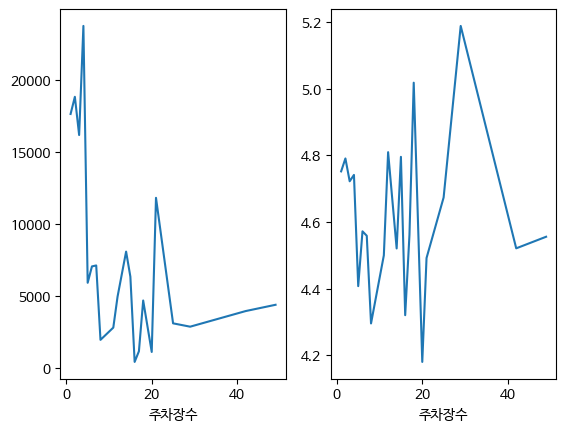

In [ ]:
plt.subplot(1,2,1)
df_parking.groupby('주차장수')['ECLO'].sum().plot()
plt.subplot(1,2,2)
df_parking.groupby('주차장수')['ECLO'].mean().plot()

<Axes: xlabel='주차장유형'>

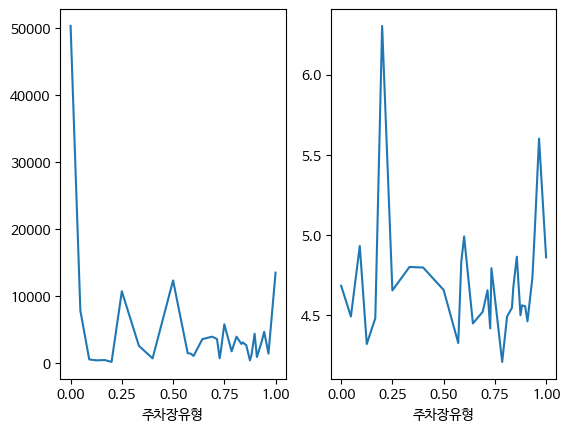

In [ ]:
plt.subplot(1,2,1)
df_parking.groupby('주차장유형')['ECLO'].sum().plot()
plt.subplot(1,2,2)
df_parking.groupby('주차장유형')['ECLO'].mean().plot()

<Axes: xlabel='주차장수'>

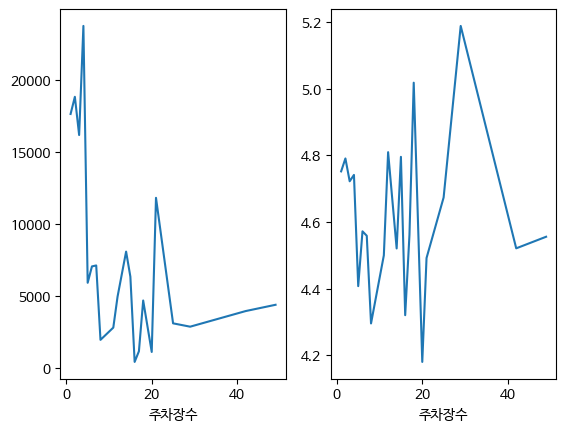

In [ ]:
plt.subplot(1,2,1)
df_parking.groupby('주차장수')['ECLO'].sum().plot()
plt.subplot(1,2,2)
df_parking.groupby('주차장수')['ECLO'].mean().plot()

(0.0, 100.0)

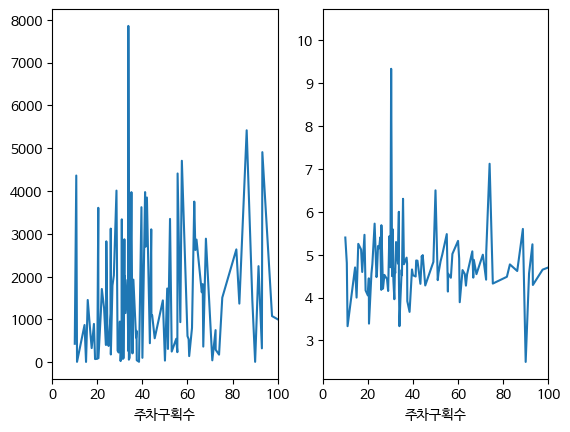

In [ ]:
plt.subplot(1,2,1)
df_parking.groupby('주차구획수')['ECLO'].sum().plot()
plt.xlim(0,100)
plt.subplot(1,2,2)
df_parking.groupby('주차구획수')['ECLO'].mean().plot()
plt.xlim(0,100)

<Axes: xlabel='운영요일'>

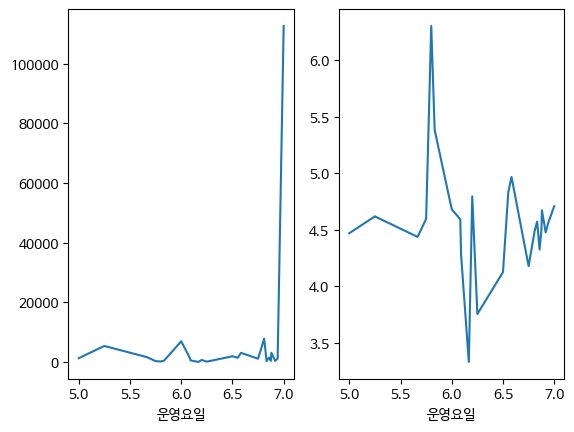

In [ ]:
plt.subplot(1,2,1)
df_parking.groupby('운영요일')['ECLO'].sum().plot()
plt.subplot(1,2,2)
df_parking.groupby('운영요일')['ECLO'].mean().plot()

# 가로망 노상주차 정보

In [ ]:
import geopandas as gpd
import glob
from itertools import chain

In [ ]:
folders = glob.glob('./open/external_open/대구 빅데이터 마트 데이터/6. 건축물/*')
files = list(chain(*[glob.glob(files+'/*.gpkg') for files in folders]))

In [ ]:
files

['./open/external_open/대구 빅데이터 마트 데이터/6. 건축물/3. 대구광역시_가로망주정차현황_노상주차면정보/노상주차_500.gpkg',
 './open/external_open/대구 빅데이터 마트 데이터/6. 건축물/3. 대구광역시_가로망주정차현황_노상주차면정보/노상주차_300.gpkg',
 './open/external_open/대구 빅데이터 마트 데이터/6. 건축물/3. 대구광역시_가로망주정차현황_노상주차면정보/노상주차_100.gpkg',
 './open/external_open/대구 빅데이터 마트 데이터/6. 건축물/7. 대구광역시_가로망주정차현황_주차단속카메라정보/주차단속카메라_500.gpkg',
 './open/external_open/대구 빅데이터 마트 데이터/6. 건축물/7. 대구광역시_가로망주정차현황_주차단속카메라정보/주차단속카메라_300.gpkg',
 './open/external_open/대구 빅데이터 마트 데이터/6. 건축물/7. 대구광역시_가로망주정차현황_주차단속카메라정보/주차단속카메라_100.gpkg',
 './open/external_open/대구 빅데이터 마트 데이터/6. 건축물/4. 대구광역시_횡단보도/횡단보도_100.gpkg',
 './open/external_ope

In [ ]:
import sqlite3

# Connect to the GeoPackage database
connection = sqlite3.connect(files[0])

# Create a cursor object to execute SQL queries
cursor = connection.cursor()

# Example SQL query to fetch all tables in the GeoPackage
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch the result
tables = cursor.fetchall()

# Print the tables in the GeoPackage
print("Tables in GeoPackage:")
for table in tables:
    print(table[0])


# Close the cursor and connection
cursor.close()


Tables in GeoPackage:
gpkg_spatial_ref_sys
gpkg_contents
gpkg_ogr_contents
gpkg_geometry_columns
gpkg_tile_matrix_set
gpkg_tile_matrix
sqlite_sequence
gpkg_extensions
노상주차_500
rtree_노상주차_500_geom
rtree_노상주차_500_geom_rowid
rtree_노상주차_500_geom_node
rtree_노상주차_500_geom_parent


In [ ]:
cursor = connection.cursor()
results = []
for table in tables:
  cursor.execute(f"SELECT * FROM {table[0]};")
  results.append(cursor.fetchall())

In [ ]:
pd.DataFrame(results[0])

,0,1,2,3,4,5
0,Undefined Cartesian SRS,-1,NONE,-1,undefined,undefined Cartesian coordinate reference system
1,Undefined geographic SRS,0,NONE,0,undefined,undefined geographic coordinate reference system
2,WGS 84 geodetic,4326,EPSG,4326,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",longitude/latitude coordinates in decimal degr...
3,Korea 2000 / Unified CS,5179,EPSG,5179,"PROJCS[""Korea 2000 / Unified CS"",GEOGCS[""Korea...",None


In [ ]:
pd.DataFrame(results[1])

,0,1,2,3,4,5,6,7,8,9
0,노상주차_500,features,노상주차_500,,2023-08-10T16:27:08.775Z,1.077033e+06,1.734853e+06,1.113966e+06,1.780587e+06,5179


In [ ]:
pd.DataFrame(results[2])

,0,1
0,노상주차_500,3776


In [ ]:
df_base = gpd.read_file('./open/external_open/대구 빅데이터 마트 데이터/0. Base/대구광역시_100.gpkg')

In [ ]:
df_base.loc[:,'geometry']

0        MULTIPOLYGON (((1077102.303 1745692.817, 10771...
1        MULTIPOLYGON (((1077057.173 1745639.546, 10770...
2        MULTIPOLYGON (((1077051.871 1745538.189, 10770...
3        MULTIPOLYGON (((1077049.547 1745487.411, 10771...
4        MULTIPOLYGON (((1077044.105 1745368.495, 10770...
                               ...                        
89311    MULTIPOLYGON (((1113905.212 1766486.883, 11138...
89312    MULTIPOLYGON (((1113847.421 1766386.670, 11138...
89313    MULTIPOLYGON (((1113852.491 1766284.918, 11138...
89314    MULTIPOLYGON (((1113842.714 1764974.150, 11138...
89315    MULTIPOLYGON (((1113966.384 1766502.594, 11139...
Name: geometry, Length: 89316, dtype: geometry

In [ ]:
df_road_park = gpd.read_file(files[2])

In [ ]:
df_p = gpd.read_file('./open/external_open/대구 빅데이터 마트 데이터/6. 건축물/4. 대구광역시_횡단보도/횡단보도_100.gpkg')

In [ ]:
df_p.shape

(89316, 3)

In [ ]:
df_p[~df_p['count'].isna()]

,id,count,geometry
2578,18476,1.0,"MULTIPOLYGON (((1081032.542 1765087.411, 10811..."
2579,18477,1.0,"MULTIPOLYGON (((1081032.542 1764987.411, 10811..."
2580,18478,1.0,"MULTIPOLYGON (((1081032.542 1764887.411, 10811..."
2581,18479,3.0,"MULTIPOLYGON (((1081032.542 1764787.411, 10811..."
2582,18480,1.0,"MULTIPOLYGON (((1081032.542 1764687.411, 10811..."
...,...,...,...
88974,165037,2.0,"MULTIPOLYGON (((1113032.542 1764987.411, 11131..."
88975,165038,2.0,"MULTIPOLYGON (((1113032.542 1764887.411, 11131..."
89037,165494,1.0,"MULTIPOLYGON (((1113132.542 1765087.411, 11132..."
89038,165495,2.0,"MULTIPOLYGON (((1113132.542 1764987.411, 11132..."


In [ ]:
df_road_park[~df_road_park['count'].isna()]

,id,count,PRK_LVL_count_1,PRK_LVL_count_2,PRK_LVL_count_3,PRK_PAY_YN_count_0,PRK_PAY_YN_count_1,PRK_PAY_YN_count_2,geometry
6788,27425,21.0,NaN,NaN,21.0,21.0,NaN,NaN,"MULTIPOLYGON (((1082932.542 1740387.411, 10830..."
7035,27883,11.0,NaN,NaN,11.0,11.0,NaN,NaN,"MULTIPOLYGON (((1083032.542 1740387.411, 10831..."
7284,28341,11.0,NaN,NaN,11.0,11.0,NaN,NaN,"MULTIPOLYGON (((1083132.542 1740387.411, 10832..."
9823,32787,1.0,NaN,NaN,1.0,1.0,NaN,NaN,"MULTIPOLYGON (((1084132.542 1753787.411, 10842..."
10101,33245,3.0,NaN,NaN,3.0,3.0,NaN,NaN,"MULTIPOLYGON (((1084232.542 1753787.411, 10843..."
...,...,...,...,...,...,...,...,...,...
86047,153597,1.0,NaN,NaN,1.0,1.0,NaN,NaN,"MULTIPOLYGON (((1110532.542 1763987.411, 11106..."
87326,157253,9.0,NaN,NaN,9.0,9.0,NaN,NaN,"MULTIPOLYGON (((1111332.542 1764787.411, 11114..."
87471,157711,11.0,NaN,NaN,11.0,11.0,NaN,NaN,"MULTIPOLYGON (((1111432.542 1764787.411, 11115..."
88771,163661,6.0,NaN,NaN,6.0,6.0,NaN,NaN,"MULTIPOLYGON (((1112732.542 1765187.411, 11128..."


In [ ]:
from shapely import Polygon
from shapely.wkt import loads

dir(df_road_park.loc[0,'geometry'])

['__and__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__xor__',
 '_geom',
 '_geom_prepared',
 '_ndim',
 '_repr_svg_',
 'almost_equals',
 'area',
 'boundary',
 'bounds',
 'buffer',
 'centroid',
 'contains',
 'contains_properly',
 'convex_hull',
 'coords',
 'covered_by',
 'covers',
 'crosses',
 'difference',
 'disjoint',
 'distance',
 'dwithin',
 'envelope',
 'equals',
 'equals_exact',
 'geom_type',
 'geometryType',
 'geoms',
 'has_z',
 'hausdorff_distance',
 'interpolate',
 'intersection',
 'intersects',
 'is_closed',
 'is_empty',
 'is_ring',
 'is_simple',
 'is_valid',
 'length',
 'line_i

# AutoGluon

In [34]:
X_train = X_train_df.copy()
X_test = X_test_df.copy()
y_train = y_train_df.copy()

In [35]:
X_train = pd.concat([X_train,y_train],axis=1)

In [36]:
X_train['ECLO'] = np.log1p(X_train['ECLO'])

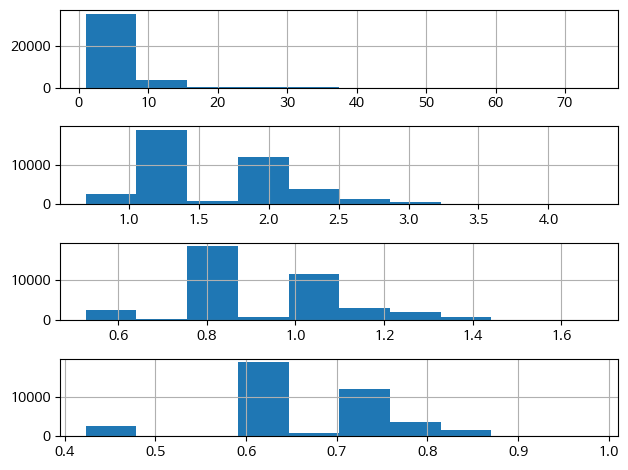

In [ ]:
plt.subplot(4,1,1)
X_train['ECLO'].hist()
plt.subplot(4,1,2)
np.log1p(X_train['ECLO']).hist()
plt.subplot(4,1,3)
np.log1p(np.log1p(X_train['ECLO'])).hist()
plt.subplot(4,1,4)
np.log1p(np.log1p(np.log1p(X_train['ECLO']))).hist()

plt.tight_layout()
plt.show()

In [37]:
trainset = TabularDataset(X_train)
testset = TabularDataset(X_test)

In [ ]:
predictor = TabularPredictor(label='ECLO', problem_type='regression' ,eval_metric='rmse').fit(trainset)

In [38]:
predictor = TabularPredictor(label='ECLO', eval_metric='rmse').fit(trainset, presets='high_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20231210_131728"
Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 3600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20231210_131728/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20231210_131728/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.

In [ ]:
predictor = TabularPredictor(label='ECLO', eval_metric='rmse').fit(trainset, presets='best_quality') # 매우 오래걸림 주의

In [39]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.444521,root_mean_squared_error,7.824335,125.909182,0.001194,1.602207,2,False,51
1,CatBoost_r50_BAG_L1,-0.444767,root_mean_squared_error,0.228618,15.201113,0.228618,15.201113,1,False,31
2,CatBoost_r137_BAG_L1,-0.444807,root_mean_squared_error,0.179779,48.007880,0.179779,48.007880,1,False,21
3,CatBoost_r69_BAG_L1,-0.444835,root_mean_squared_error,0.126453,21.571652,0.126453,21.571652,1,False,35
4,XGBoost_r89_BAG_L1,-0.444836,root_mean_squared_error,1.308424,7.746058,1.308424,7.746058,1,False,27
...,...,...,...,...,...,...,...,...,...,...
97,CatBoost_r177_BAG_L1_FULL,NaN,root_mean_squared_error,NaN,2.057628,NaN,2.057628,1,True,63
98,CatBoost_r167_BAG_L1_FULL,NaN,root_mean_squared_error,NaN,2.049044,NaN,2.049044,1,True,95
99,CatBoost_r13_BAG_L1_FULL,NaN,root_mean_squared_error,NaN,10.263465,NaN,10.263465,1,True,74
100,CatBoost_r137_BAG_L1_FULL,NaN,root_mean_squared_error,NaN,4.187310,NaN,4.187310,1,True,72


In [ ]:
predictor.feature_importance(data=trainset)

In [41]:
pred = predictor.predict(testset)

In [186]:
pred = predictor.predict(testset, model='WeightedEnsemble_L2')

In [42]:
pred = np.exp(pred) - 1

In [43]:
pred.min()

2.5304832

In [ ]:
pred = np.where(pred < 0, 0, pred)

<Axes: ylabel='Frequency'>

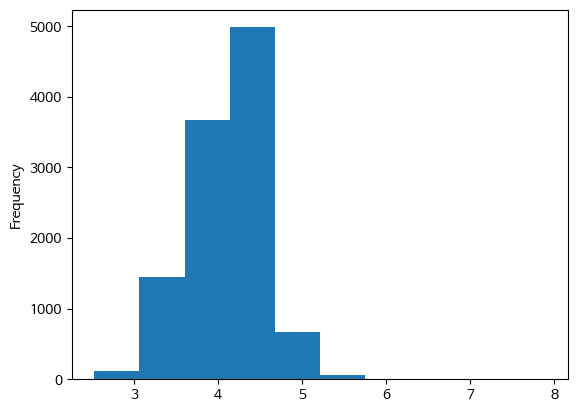

In [44]:
pred.plot(kind='hist')

In [45]:
submit = pd.read_csv('./open/sample_submission.csv')
submit.loc[X_test.index, 'ECLO'] = pred
submit

,ID,ECLO
0,ACCIDENT_39609,4.168595
1,ACCIDENT_39610,3.906022
2,ACCIDENT_39611,5.154377
3,ACCIDENT_39612,4.647350
4,ACCIDENT_39613,4.625804
...,...,...
10958,ACCIDENT_50567,5.176826
10959,ACCIDENT_50568,4.504848
10960,ACCIDENT_50569,4.657367
10961,ACCIDENT_50570,4.617970


In [46]:
submit.to_csv('./submit/20231210-2334.csv', index=False)

,ID,ECLO
0,ACCIDENT_39609,4.112649
1,ACCIDENT_39610,3.633142
2,ACCIDENT_39611,4.994686
3,ACCIDENT_39612,4.531522
4,ACCIDENT_39613,4.599784
...,...,...
10958,ACCIDENT_50567,5.814906
10959,ACCIDENT_50568,4.280996
10960,ACCIDENT_50569,4.463435
10961,ACCIDENT_50570,4.323421


# Temp

## 보안등

In [ ]:
light = pd.read_csv("./open/external_open/대구 보안등 정보.csv",encoding = 'cp949')

In [ ]:
light

,보안등위치명,설치개수,소재지도로명주소,소재지지번주소,위도,경도,설치연도,설치형태
0,대명1동1,1,대구광역시 남구 현충로 155,대구광역시 남구 대명동 1722-4,35.846703,128.579803,2016.0,한전주
1,대명1동2,1,대구광역시 남구 현충로31길 10-1,대구광역시 남구 대명동 1723-11,35.846863,128.579406,2016.0,한전주
2,대명1동3,1,대구광역시 남구 현충로31길 9-8,대구광역시 남구 대명동 1722-56,35.846341,128.579342,2017.0,건축물
3,대명1동4,2,대구광역시 남구 현충로31길 19-11,대구광역시 남구 대명동 1722-41,35.846368,128.578922,2016.0,한전주
4,대명1동5,1,대구광역시 남구 현충로29길 22-2,대구광역시 남구 대명동 1721-22,35.845995,128.578858,2016.0,한전주
...,...,...,...,...,...,...,...,...
71908,대봉2동 165-9,1,NaN,대구광역시 중구 대봉동 165-9,35.857556,128.600023,NaN,한전주
71909,대봉2동 88-85,1,NaN,대구광역시 중구 대봉동 88-85,35.859205,128.600046,NaN,한전주
71910,대봉2동 719-20,1,NaN,대구광역시 중구 대봉동 719-20,35.859442,128.599627,NaN,한전주
71911,대봉2동 738-13,1,NaN,대구광역시 중구 대봉동 738-13,35.858244,128.597614,2010.0,건축물


In [ ]:
light_df = light[['설치개수','소재지지번주소']]

In [ ]:
light_df

,설치개수,소재지지번주소
0,1,대구광역시 남구 대명동 1722-4
1,1,대구광역시 남구 대명동 1723-11
2,1,대구광역시 남구 대명동 1722-56
3,2,대구광역시 남구 대명동 1722-41
4,1,대구광역시 남구 대명동 1721-22
...,...,...
71908,1,대구광역시 중구 대봉동 165-9
71909,1,대구광역시 중구 대봉동 88-85
71910,1,대구광역시 중구 대봉동 719-20
71911,1,대구광역시 중구 대봉동 738-13


In [ ]:
import re
p = r'(\S+) (\S+) (\S+) (\S+)'

light_df[['도시','구','동','번지']] = light_df['소재지지번주소'].str.extract(p)


In [ ]:
light_df

,설치개수,소재지지번주소,도시,구,동,번지
0,1,대구광역시 남구 대명동 1722-4,대구광역시,남구,대명동,1722-4
1,1,대구광역시 남구 대명동 1723-11,대구광역시,남구,대명동,1723-11
2,1,대구광역시 남구 대명동 1722-56,대구광역시,남구,대명동,1722-56
3,2,대구광역시 남구 대명동 1722-41,대구광역시,남구,대명동,1722-41
4,1,대구광역시 남구 대명동 1721-22,대구광역시,남구,대명동,1721-22
...,...,...,...,...,...,...
71908,1,대구광역시 중구 대봉동 165-9,대구광역시,중구,대봉동,165-9
71909,1,대구광역시 중구 대봉동 88-85,대구광역시,중구,대봉동,88-85
71910,1,대구광역시 중구 대봉동 719-20,대구광역시,중구,대봉동,719-20
71911,1,대구광역시 중구 대봉동 738-13,대구광역시,중구,대봉동,738-13


In [ ]:
light_df.drop(columns = ['소재지지번주소','번지'],inplace = True)

In [ ]:
light_df

,설치개수,도시,구,동
0,1,대구광역시,남구,대명동
1,1,대구광역시,남구,대명동
2,1,대구광역시,남구,대명동
3,2,대구광역시,남구,대명동
4,1,대구광역시,남구,대명동
...,...,...,...,...
71908,1,대구광역시,중구,대봉동
71909,1,대구광역시,중구,대봉동
71910,1,대구광역시,중구,대봉동
71911,1,대구광역시,중구,대봉동


In [ ]:
light_df = light_df.groupby(['도시','구','동']).sum().reset_index()

In [ ]:
light_df

,도시,구,동,설치개수
0,대구광역시,남구,대명동,5377
1,대구광역시,남구,봉덕동,1424
2,대구광역시,남구,이천동,556
3,대구광역시,달서구,갈산동,349
4,대구광역시,달서구,감삼동,932
...,...,...,...,...
223,대구광역시,중구,태평로2가,38
224,대구광역시,중구,태평로3가,47
225,대구광역시,중구,포정동,18
226,대구광역시,중구,향촌동,28


In [ ]:
light_df['시군구'] = light_df['도시']+' '+light_df['구']+' '+light_df['동']

In [ ]:
light_df

,도시,구,동,설치개수,시군구
0,대구광역시,남구,대명동,5377,대구광역시 남구 대명동
1,대구광역시,남구,봉덕동,1424,대구광역시 남구 봉덕동
2,대구광역시,남구,이천동,556,대구광역시 남구 이천동
3,대구광역시,달서구,갈산동,349,대구광역시 달서구 갈산동
4,대구광역시,달서구,감삼동,932,대구광역시 달서구 감삼동
...,...,...,...,...,...
223,대구광역시,중구,태평로2가,38,대구광역시 중구 태평로2가
224,대구광역시,중구,태평로3가,47,대구광역시 중구 태평로3가
225,대구광역시,중구,포정동,18,대구광역시 중구 포정동
226,대구광역시,중구,향촌동,28,대구광역시 중구 향촌동


In [ ]:
train = pd.read_csv("./open/train.csv")
test = pd.read_csv("./open/test.csv")

In [ ]:
merge_df_train = pd.merge(train,light_df,how = "left",on = '시군구')
merge_df_test = pd.merge(test,light_df,how = "left",on = '시군구')

In [ ]:
train_check_address = []
test_check_address = []
for address in train['시군구'].value_counts().index.to_list():
  if address not in light_df['시군구'].value_counts().index.to_list():
    train_check_address.append(address)

for address in test['시군구'].value_counts().index.to_list():
  if address not in light_df['시군구'].value_counts().index.to_list():
    test_check_address.append(address)

In [ ]:
train_check_address.sort()
test_check_address.sort()

## mergd_df에 데이터 추가

In [ ]:
test_check_address == train_check_address

True

In [ ]:
# 보안등 정보가 없는 train의 시군구 정보
train_check_address

['대구광역시 달성군 옥포읍',
 '대구광역시 달성군 현풍읍',
 '대구광역시 북구 사수동',
 '대구광역시 서구 내당동',
 '대구광역시 서구 비산동',
 '대구광역시 서구 상리동',
 '대구광역시 서구 원대동1가',
 '대구광역시 서구 원대동2가',
 '대구광역시 서구 원대동3가',
 '대구광역시 서구 이현동',
 '대구광역시 서구 중리동',
 '대구광역시 서구 평리동',
 '대구광역시 수성구 가천동',
 '대구광역시 수성구 고모동',
 '대구광역시 수성구 노변동',
 '대구광역시 수성구 대흥동',
 '대구광역시 수성구 만촌동',
 '대구광역시 수성구 매호동',
 '대구광역시 수성구 범물동',
 '대구광역시 수성구 범어동',
 '대구광역시 수성구 사월동',
 '대구광역시 수성구 삼덕동',
 '대구광역시 수성구 성동',
 '대구광역시 수성구 수성동1가',
 '대구광역시 수성구 수성동2가',
 '대구광역시 수성구 수성동3가',
 '대구광역시 수성구 수성동4가',
 '대구광역시 수성구 시지동',
 '대구광역시 수성구 신매동',
 '대구광역시 수성구 연호동',
 '대구광역시 수성구 욱수동',
 '대구광역시 수성구 이천동',
 '대구광역시 수성구 지산동',
 '대구광역시 수성구 황금동',
 '대구광역시 중구 하서동']

보안등의 엑셀 데이터 확인해서 채울 수 있는건 직접 채움

In [ ]:
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 달성군 현풍읍','설치개수'] = 524
merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 달성군 현풍읍','설치개수'] = 524

In [ ]:
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 서구 내당동','설치개수'] = (420+664+446)
merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 서구 내당동','설치개수'] = (420+664+446)

In [ ]:
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 서구 비산동','설치개수'] = (611+972+483+858)
merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 서구 비산동','설치개수'] = (611+972+483+858)

In [ ]:
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 서구 원대동1가','설치개수'] = 704//3
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 서구 원대동2가','설치개수'] = 704//3
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 서구 원대동3가','설치개수'] = 704//3

merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 서구 원대동1가','설치개수'] = 704//3
merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 서구 원대동2가','설치개수'] = 704//3
merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 서구 원대동3가','설치개수'] = 704//3

In [ ]:
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 서구 평리동','설치개수'] = (535+360+619+457+346+404)
merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 서구 평리동','설치개수'] = (535+360+619+457+346+404)

In [ ]:
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 수성구 만촌동','설치개수'] = (677+593+449)
merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 수성구 만촌동','설치개수'] = (677+593+449)

In [ ]:
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 수성구 범물동','설치개수'] = (192+198)
merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 수성구 범물동','설치개수'] = (192+198)

In [ ]:
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 수성구 범어동','설치개수'] = (408+645+462+429)
merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 수성구 범어동','설치개수'] = (408+645+462+429)

In [ ]:
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 수성구 삼덕동','설치개수'] = (1+90+150+179)
merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 수성구 삼덕동','설치개수'] = (1+90+150+179)

In [ ]:
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 수성구 지산동','설치개수'] = (616+25)
merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 수성구 지산동','설치개수'] = (616+25)

In [ ]:
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 수성구 황금동','설치개수'] = (153+590)
merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 수성구 황금동','설치개수'] = (153+590)

In [ ]:
merge_df_train.loc[merge_df_train['시군구'] == '대구광역시 수성구 황금동','설치개수'] = (153+590)
merge_df_test.loc[merge_df_test['시군구'] == '대구광역시 수성구 황금동','설치개수'] = (153+590)

In [ ]:
merge_df_train['설치개수'].isnull().sum()

2799

In [ ]:
merge_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           39609 non-null  object 
 1   사고일시         39609 non-null  object 
 2   요일           39609 non-null  object 
 3   기상상태         39609 non-null  object 
 4   시군구          39609 non-null  object 
 5   도로형태         39609 non-null  object 
 6   노면상태         39609 non-null  object 
 7   사고유형         39609 non-null  object 
 8   사고유형 - 세부분류  39609 non-null  object 
 9   법규위반         39609 non-null  object 
 10  가해운전자 차종     39609 non-null  object 
 11  가해운전자 성별     39609 non-null  object 
 12  가해운전자 연령     39609 non-null  object 
 13  가해운전자 상해정도   39609 non-null  object 
 14  피해운전자 차종     38618 non-null  object 
 15  피해운전자 성별     38618 non-null  object 
 16  피해운전자 연령     38618 non-null  object 
 17  피해운전자 상해정도   38618 non-null  object 
 18  사망자수         39609 non-null  int64  
 19  중상자수

In [ ]:
merge_df_train.to_csv("./train_light.csv",encoding = 'utf-8',index=False)
merge_df_test.to_csv("./test_light.csv",encoding = 'utf-8',index=False)